In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pearson_util 
import descartes
import pygeoj
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import statsmodels.api as sm
from shapely.geometry import Polygon
import seaborn as sns

# Complete Model

Code for all models

In [2]:
# Load gdf of NUTS 3 regions
gdf_dw = gpd.read_file('C:/Users/seanp/python/NUTS_RG_60M_2016_3035_LEVL_3.geojson')


# Load Transport Demand Prediction (Unit Mio_Vkm)
Mio_Vkm = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'vkm_distance_class')
Mio_Vkm = Mio_Vkm.set_index(['country','distance_class'])



# Load Fuel Efficiency for each country and fuel type (Unit kWh/km)
kWh_km = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Vehicle Fuel Efficiency/FE_By_Country_P.xlsm', sheet_name = 'FE_D')
kWh_km = kWh_km.set_index(['country','distance_class','Powertrain'])

# Load the transport share of each region compared to it's country
#transport_share_region = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/transport_share_region.xlsx', sheet_name = 'regional_transport_share_2050')
#transport_share_region = transport_share_region.set_index(['country','id'])

In [4]:
# loading and unloading dataset for all NUTS 3 regions and calculating transport share for each region
# Loading dataset
df_loading = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_ta_rl.tsv.gz',['id', 'unit', 'region'])
# dropping unnecessary units (leaving Mio VKM) 
df_loading_MIO_TKM = df_loading.drop(index = ['THS_JRNY', 'THS_T'], level = 1)
# droppinh unnecessary regions (leaving EU28, CH, NO)
df_loading_MIO_TKM_drop = df_loading_MIO_TKM.drop(index = ['EU27_2020', 'EU27_2007', 'EU25', 'EU15', 'BE', 'BG', 'CZ', 'DK', 'DE', 'EE', 'IE', 'EL', 'CY', 'MK', 'ME', 'ES', 'FR', 'HR', 'IT', 'LV', 'LT', 'LU', 'HU', 'NL', 'AT', 'PL', 'PT', 'RO', 'SI', 'SK', 'FI', 'SE', 'UK'], level = 2)
# sum of EU28, CH, NO
df_loading_MIO_TKM_drop_sum = df_loading_MIO_TKM_drop.groupby('id').sum()
# setting index to same index as gdf to delete all unecessary regions
df_loading_nuts3 = df_loading_MIO_TKM_drop_sum.reindex(gdf_dw.set_index('id').index)


df_unloading = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_ta_ru.tsv.gz',['id', 'unit', 'region'])
df_unloading_MIO_TKM = df_unloading.drop(index = ['THS_JRNY', 'THS_T'], level = 1)
df_unloading_MIO_TKM_drop = df_unloading_MIO_TKM.drop(index = ['EU27_2020', 'EU27_2007', 'EU25', 'EU15', 'BE', 'BG', 'CZ', 'DK', 'DE', 'EE', 'IE', 'EL', 'CY', 'MK', 'ME', 'ES', 'FR', 'HR', 'IT', 'LV', 'LT', 'LU', 'HU', 'NL', 'AT', 'PL', 'PT', 'RO', 'SI', 'SK', 'FI', 'SE', 'UK'], level = 2)
df_unloading_MIO_TKM_drop_sum = df_unloading_MIO_TKM_drop.groupby('id').sum()
df_unloading_nuts3 = df_unloading_MIO_TKM_drop_sum.reindex(gdf_dw.set_index('id').index)

# combining unloading and loading table and calculating average of loading and unloading
df_average_transport_total = pd.concat((df_unloading_nuts3, df_loading_nuts3))
df_average_transport_NUTS3 = df_average_transport_total.groupby(df_average_transport_total.index).mean()

# create country code index
df_average_transport_NUTS3_filtered_test = df_average_transport_NUTS3.reset_index()
country_codes = df_average_transport_NUTS3_filtered_test.id.str.slice(stop=2)
country_codes = country_codes.to_frame(name = 'country')
df_average_transport_NUTS3_test = df_average_transport_NUTS3.reset_index()
df_average_transport_CC_NUTS3 = df_average_transport_NUTS3_test.join(country_codes)
df_average_transport_CC_NUTS3 = df_average_transport_CC_NUTS3.set_index(['id','country'])

# load total transport for each country and filter proper countries and units etc.
transport_country = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_ta_tott.tsv.gz',['carriage', 'operation', 'unit','country'])
transport_country = transport_country.loc['TOT']
transport_country = transport_country.loc['TOTAL']
transport_country = transport_country.loc['MIO_TKM']
transport_country = transport_country.drop(['EU15', 'EU25', 'EU27_2007', 'EU27_2020', 'EU28', 'LI'])
transport_country_filledna = transport_country.interpolate(method ='linear', axis = 1, limit_direction ='backward')

# divide regional transport by nation transport to get transport share of each region
transport_share_NUTS3 = df_average_transport_CC_NUTS3.div(transport_country_filledna)

# get rid of space in column titels
transport_share_NUTS3.columns = transport_share_NUTS3.columns.str.replace(' ', '')
transport_share_NUTS3.columns = transport_share_NUTS3.columns.astype(str)

# replace 0 with NaN so it does not take that into account when calculating mean
# drop years before 2015 so it does not take that into account when calculating mean
transport_share_NUTS3 = transport_share_NUTS3.replace(0, np.NaN)
transport_share_NUTS3 = transport_share_NUTS3.drop(columns = ['2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007', '2006', '2005', '2004', '2003', '2002', '2001', '2000', '1999'])
transport_share_NUTS3_mean = transport_share_NUTS3.mean(axis=1)
t_s_NUTS3 = transport_share_NUTS3_mean.to_frame(name = '2020')

# Add columns to dataframe so it has the same amount of years 2020 - 2050 as the other df
t_s_NUTS3['2021'] = t_s_NUTS3['2020']
t_s_NUTS3['2022'] = t_s_NUTS3['2020']
t_s_NUTS3['2023'] = t_s_NUTS3['2020']
t_s_NUTS3['2024'] = t_s_NUTS3['2020']
t_s_NUTS3['2025'] = t_s_NUTS3['2020']
t_s_NUTS3['2026'] = t_s_NUTS3['2020']
t_s_NUTS3['2027'] = t_s_NUTS3['2020']
t_s_NUTS3['2028'] = t_s_NUTS3['2020']
t_s_NUTS3['2029'] = t_s_NUTS3['2020']
t_s_NUTS3['2030'] = t_s_NUTS3['2020']
t_s_NUTS3['2031'] = t_s_NUTS3['2020']
t_s_NUTS3['2032'] = t_s_NUTS3['2020']
t_s_NUTS3['2033'] = t_s_NUTS3['2020']
t_s_NUTS3['2034'] = t_s_NUTS3['2020']
t_s_NUTS3['2035'] = t_s_NUTS3['2020']
t_s_NUTS3['2036'] = t_s_NUTS3['2020']
t_s_NUTS3['2037'] = t_s_NUTS3['2020']
t_s_NUTS3['2038'] = t_s_NUTS3['2020']
t_s_NUTS3['2039'] = t_s_NUTS3['2020']
t_s_NUTS3['2040'] = t_s_NUTS3['2020']
t_s_NUTS3['2041'] = t_s_NUTS3['2020']
t_s_NUTS3['2042'] = t_s_NUTS3['2020']
t_s_NUTS3['2043'] = t_s_NUTS3['2020']
t_s_NUTS3['2044'] = t_s_NUTS3['2020']
t_s_NUTS3['2045'] = t_s_NUTS3['2020']
t_s_NUTS3['2046'] = t_s_NUTS3['2020']
t_s_NUTS3['2047'] = t_s_NUTS3['2020']
t_s_NUTS3['2048'] = t_s_NUTS3['2020']
t_s_NUTS3['2049'] = t_s_NUTS3['2020']
t_s_NUTS3['2050'] = t_s_NUTS3['2020']
#t_s_NUTS3.columns.astype(str)

# change column tital type to int so it is compatible with other df
t_s_NUTS3.columns = t_s_NUTS3.columns.astype('int32')

In [5]:
# reindex transport_share_region df with the index of gdf_df and create a multiindex with country code and NUTS 3 code
#transport_share_region = transport_share_region.droplevel(0)
#transport_share_region = transport_share_region.reindex(gdf_dw.set_index('id').index)
#transport_share_region = transport_share_region.set_index(gdf_dw.set_index('CNTR_CODE').index.rename('country'), append=True)

In [6]:
# set id as index
gdf_dw = gdf_dw.set_index('id')

In [7]:
# drop unnecessary regions
gdf_dw = gdf_dw[~gdf_dw.CNTR_CODE.str.startswith('TR')]
#gdf_dw = gdf_dw[~gdf_dw.CNTR_CODE.str.startswith('AL')]
gdf_dw = gdf_dw.drop(['ES708', 'ES704', 'ES705', 'ES709', 'ES706', 'ES703', 'ES707', 'CY000', 'FRY10', 'FRY20', 'FRY30', 'FRY40', 'FRY50', 'PT300', 'PT200', 'IS002'])

In [8]:
# Adjust units from Mio_Vkm to Vkm
Vkm = Mio_Vkm.multiply(1000000)

In [9]:
# Multiply kWh/km of each powertrain technology by total Vkm to get the kWh of the Vehicle fleet if 100% of vehicles used one powertrain technology
kWh_all_powertrains = Vkm.multiply(kWh_km)

In [10]:
# Load gdf of Roads in Europe and transform the coordinate reference system
roads=gpd.read_file('C:/Users/seanp/Desktop/Roads_Europe')
roads_crs_3035 = roads.to_crs(epsg = 3035)

In [11]:
# create df with road length of NUTS regions in km
road_m = roads_crs_3035.length
road_m = road_m.to_frame(name = 'road_m')
road_m = roads_crs_3035.join(road_m)
roads_nuts = gpd.sjoin(gdf_dw, road_m)
road_nuts_length = roads_nuts.groupby('id').sum()
road_nuts_length_select = road_nuts_length.drop(columns=['COAST_TYPE', 'MOUNT_TYPE', 'LEVL_CODE', 'URBN_TYPE', 'index_right', 'FCsubtype', 'COR', 'EXS', 'LLE', 'LTN', 'MED', 'RST', 'RSU', 'RTT', 'TEN', 'TOL', 'TUC', 'SHAPE_Leng'])
road_km_select = road_nuts_length_select.div(1000)
road_km_select = road_km_select.rename(columns = {'road_m': 'road_km'})

In [12]:
# create df with area of NUTS regions in km^2
gdf_dw['area_km^2'] = gdf_dw.area/1000000
NUTS_Area = gdf_dw.drop(columns=['COAST_TYPE', 'MOUNT_TYPE', 'NAME_LATN', 'CNTR_CODE', 'FID', 'NUTS_ID',
       'NUTS_NAME', 'LEVL_CODE', 'URBN_TYPE', 'geometry'])
gdf_dw = gdf_dw.drop(columns=['area_km^2'])

Code for individual Scenarios

BEV_CEV Scenario

In [13]:
# Load results of the Scenarios produced by the VSM
powertrain_share_BEV_CEV = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Scenarios/VSM_Results/VSM_Results_Safe.xlsx', sheet_name = 'BEV_CEV')
powertrain_share_BEV_CEV = powertrain_share_BEV_CEV.set_index(['Lifetime','distance_class','Powertrain'])

In [14]:
# delete 'Total' from index in powertrain_share df
pow_share_BEV_CEV = powertrain_share_BEV_CEV.drop(index = 'Total', level = 2)

In [15]:
# select average life time of vehicles for this scenario (8y, 10y, 12y, 14y, 16y, 18y, 20y, 22y)
powertrain_share_10y_BEV_CEV = pow_share_BEV_CEV.loc['10y']

In [16]:
# multiply kWh if 100% of powertrains were using each technology, by the actual share of powertrains using each technology to get the total kWh demand of the vehicle fleet
kWh_tot_BEV_CEV = kWh_all_powertrains.multiply(powertrain_share_10y_BEV_CEV)

In [17]:
# multiply by konstand to transform kWh into gWh
gWh_tot_BEV_CEV = kWh_tot_BEV_CEV.multiply(0.000001)

In [18]:
# creats df with total gWh per powertrain technology
gWh_Powertrain_BEV_CEV = gWh_tot_BEV_CEV.groupby('Powertrain').sum()

In [19]:
# devide the total gWh demand of the vehicle fleet per country up into the NUTS 3 regions of each country
gWh_tot_region_BEV_CEV = gWh_tot_BEV_CEV.multiply(t_s_NUTS3)

In [20]:
# Sum up the gWh of each distance class and powertrain technology for each NUTS 3 region
gWh_tot_region_tot_BEV_CEV = gWh_tot_region_BEV_CEV.groupby('id').sum()

In [21]:
# join gdf of NUTS 3 regions with gWh per region so it can assign the road_m to the correct NUTS 3 region
gdf_gWh_tot_region_tot_BEV_CEV = gdf_dw.join(gWh_tot_region_tot_BEV_CEV)

In [22]:
# devide gWh of each year 2020 - 2050 by road_m to norm the NUTS 3 regions for their size difference
road_km_select.columns = road_km_select.columns.astype(str)
gdf_gWh_tot_region_tot_BEV_CEV.columns = gdf_gWh_tot_region_tot_BEV_CEV.columns.astype(str)
gWh_div_roadkm_perRegion_BEV_CEV = gdf_gWh_tot_region_tot_BEV_CEV[['2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050']].div(road_km_select.road_km, axis = 0)

In [23]:
#join gdf of NUTS 3 regions with gWh per road_km
gdf_gWh_div_roadkm_perRegion_BEV_CEV = gdf_dw.join(gWh_div_roadkm_perRegion_BEV_CEV)

# Plotting Results

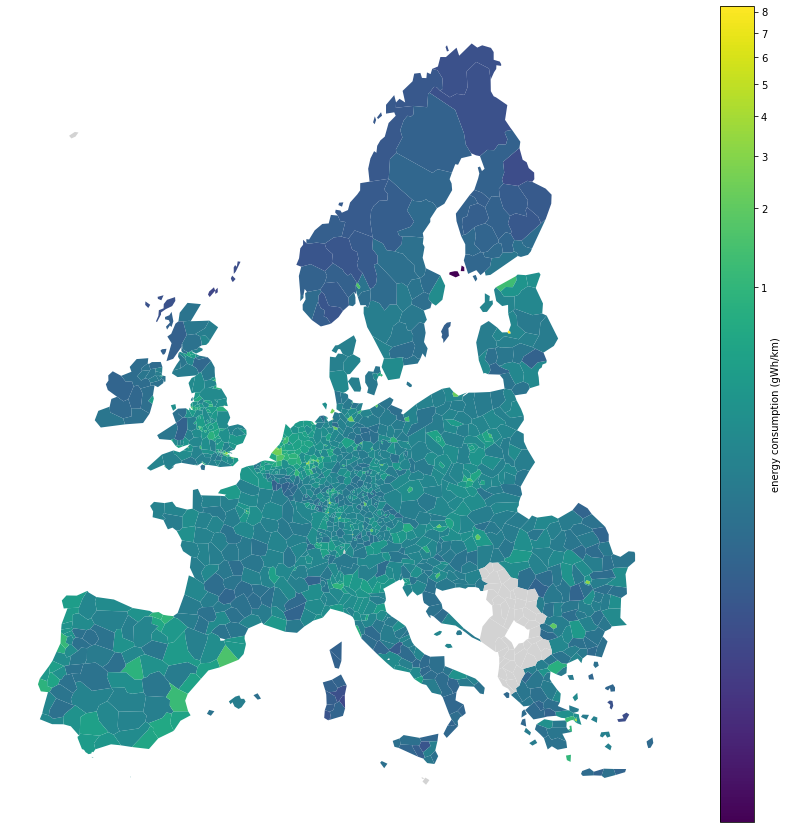

In [24]:
# Plot results
gdf_gWh_div_roadkm_perRegion_BEV_CEV = gdf_gWh_div_roadkm_perRegion_BEV_CEV.replace(0, np.nan)

fig, ax = plt.subplots(1, 1, figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax.axis('off')

gdf_gWh_div_roadkm_perRegion_BEV_CEV.plot(column = '2050', 
                                  ax=ax,
                                 legend=True,
                                  cax = cax,
                                  legend_kwds = {'label': 'energy consumption (gWh/km)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.2),
                                 missing_kwds= dict(color = "lightgrey"))

fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/gWh_div_roadkm_new.png")

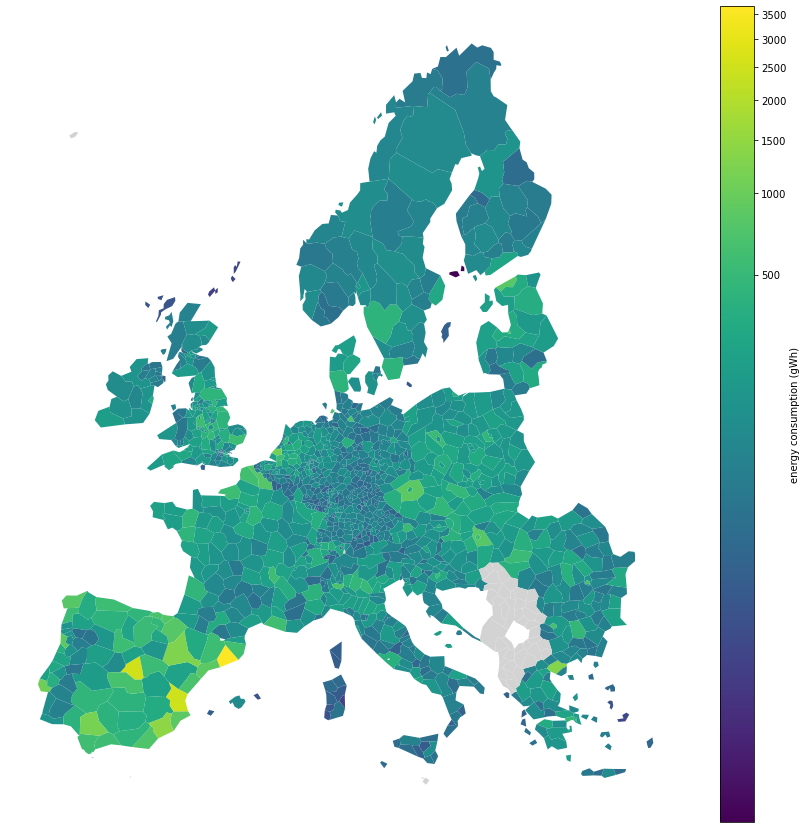

In [25]:
gdf_gWh_tot_region_tot_BEV_CEV = gdf_gWh_tot_region_tot_BEV_CEV.replace(0, np.nan)

fig, ax = plt.subplots(1, 1, figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax.axis('off')

gdf_gWh_tot_region_tot_BEV_CEV.plot(column = '2050', 
                                  ax=ax,
                                 legend=True,
                                  cax = cax,
                                  legend_kwds = {'label': 'energy consumption (gWh)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.2),
                                 missing_kwds= dict(color = "lightgrey"))

fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/gWh_new.png")

In [26]:
# Dropping regions and islands that are not part of the analysis
gWh_tot_region_tot_BEV_CEV.columns = gWh_tot_region_tot_BEV_CEV.columns.astype(str)
#gWh_tot_region_tot_BEV_CEV = gWh_tot_region_tot_BEV_CEV[~gWh_tot_region_tot_BEV_CEV.index.str.startswith('AL')]
gWh_tot_region_tot_BEV_CEV = gWh_tot_region_tot_BEV_CEV[~gWh_tot_region_tot_BEV_CEV.index.str.startswith('TR')]
gWh_tot_region_tot_BEV_CEV = gWh_tot_region_tot_BEV_CEV.drop(['ES708', 'ES704', 'ES705', 'ES709', 'ES706', 'ES703', 'ES707', 'CY000', 'FRY10', 'FRY20', 'FRY30', 'FRY40', 'FRY50', 'PT300', 'PT200', 'IS002'])

In [27]:
#select column 2050 and set it as dataframe
gWh_tot_region_tot_BEV_CEV_2050 = gWh_tot_region_tot_BEV_CEV.loc[:,'2050']
gWh_tot_region_tot_BEV_CEV_2050 = gWh_tot_region_tot_BEV_CEV_2050.to_frame(name = '2050')
tot_gWh = gWh_tot_region_tot_BEV_CEV_2050.sum()

In [28]:
# 0.75q = number where 75% of regions have that or less
gWh_tot_region_tot_BEV_CEV_2050_075q = gWh_tot_region_tot_BEV_CEV_2050.quantile(q = 0.75)
gWh_tot_region_tot_BEV_CEV_2050_075q

2050    165.286901
Name: 0.75, dtype: float64

In [29]:
# top 25% regions with the most energy demand
top_25q_regions=gWh_tot_region_tot_BEV_CEV_2050[gWh_tot_region_tot_BEV_CEV_2050['2050'] > 167.757706]
top_25_gWh = top_25q_regions.sum()

In [30]:
# 0.9q = number where 90% of regions have that or less
gWh_tot_region_tot_BEV_CEV_2050_09q = gWh_tot_region_tot_BEV_CEV_2050.quantile(q = 0.9)
top_10q_regions=gWh_tot_region_tot_BEV_CEV_2050[gWh_tot_region_tot_BEV_CEV_2050['2050'] > 377.305798]
top_10q_gWh = top_10q_regions.sum()

In [31]:
# top 10% regions with the highest energy demand per km road
gWh_div_roadkm_perRegion_BEV_CEV_09q = gWh_div_roadkm_perRegion_BEV_CEV.quantile(q = 0.9)
top_10q_regions_divKm=gWh_div_roadkm_perRegion_BEV_CEV[gWh_div_roadkm_perRegion_BEV_CEV['2050'] > 0.603242]

In [32]:
# top 25% regions with the highest energy demand per km road
gWh_div_roadkm_perRegion_BEV_CEV_075q = gWh_div_roadkm_perRegion_BEV_CEV.quantile(q = 0.75)
top_25q_regions_divKm=gWh_div_roadkm_perRegion_BEV_CEV[gWh_div_roadkm_perRegion_BEV_CEV['2050'] > 0.313139]

In [33]:
# 0.9q = number where 90% of regions have that or less
# top 10 regions witht he highest energy demand for their vehicle fleet
gWh_Region_BEV_CEV_09q = gWh_tot_region_tot_BEV_CEV.quantile(q = 0.75)
top_10q_regions = gWh_tot_region_tot_BEV_CEV[gWh_tot_region_tot_BEV_CEV['2050'] > 377.305798]
top_10q_gWh = top_10q_regions.sum()

<AxesSubplot:>

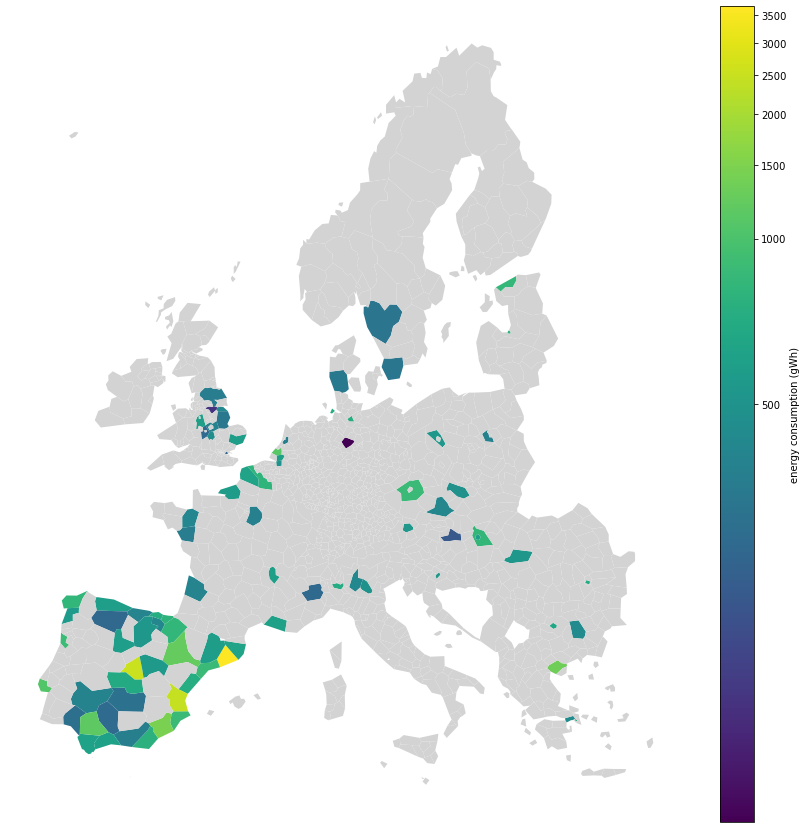

In [34]:
# plotting the top 10% regions with the highest energy demand in europe
gdf_top_10q_regions = gdf_dw.join(top_10q_regions)
gdf_top_10q_regions = gdf_top_10q_regions.replace(0, np.nan)

fig, ax = plt.subplots(1, 1, figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax.axis('off')

gdf_top_10q_regions.plot(column = '2050', 
                                  ax=ax,
                                 legend=True,
                                  cax = cax,
                                  legend_kwds = {'label': 'energy consumption (gWh)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.2),
                                 missing_kwds= dict(color = "lightgrey"))

<AxesSubplot:>

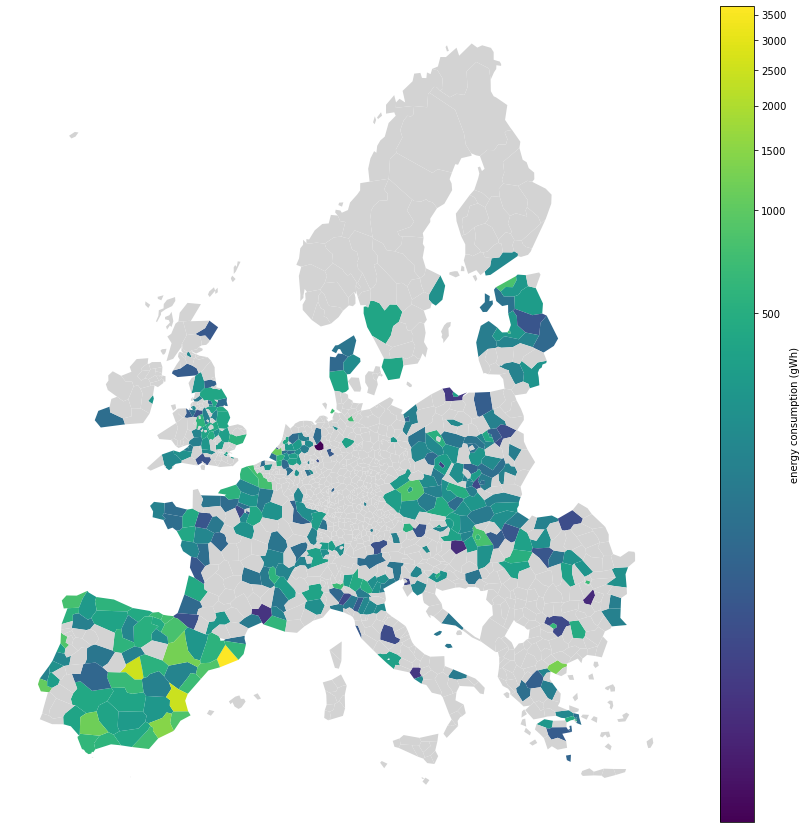

In [35]:
# plotting the top 25% regions with the highest energy demand in europe
gdf_top_25q_regions = gdf_dw.join(top_25q_regions)
gdf_top_25q_regions = gdf_top_25q_regions.replace(0, np.nan)

fig, ax = plt.subplots(1, 1, figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax.axis('off')

gdf_top_25q_regions.plot(column = '2050', 
                                  ax=ax,
                                 legend=True,
                                  cax = cax,
                                  legend_kwds = {'label': 'energy consumption (gWh)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.2),
                                 missing_kwds= dict(color = "lightgrey"))

<AxesSubplot:>

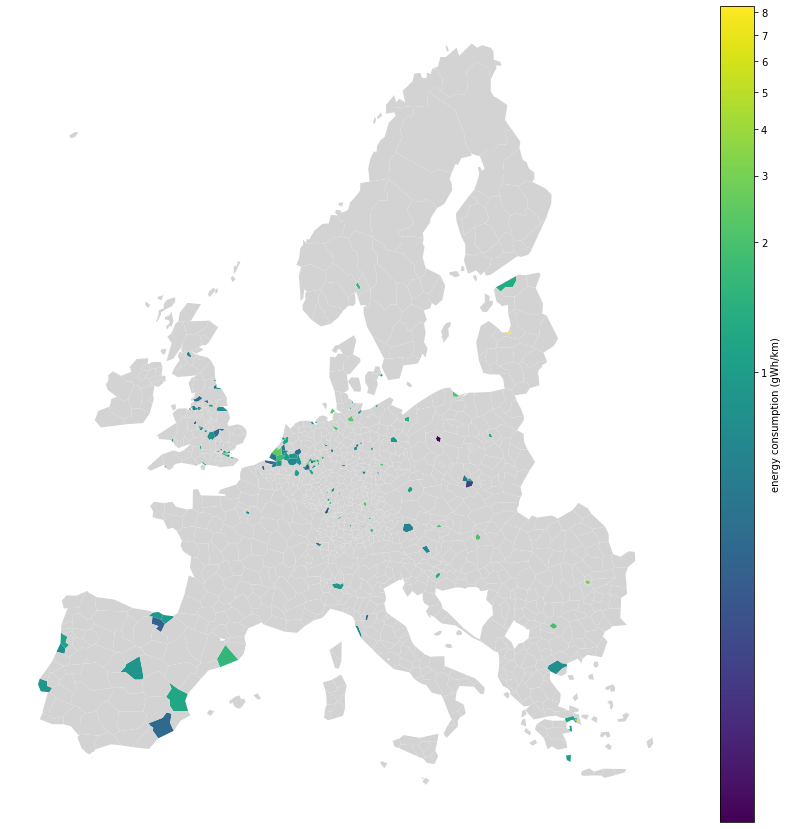

In [36]:
# plotting the top 10% regions div by road km with the highes energy demand in europe
gdf_top_10q_regions_divKm = gdf_dw.join(top_10q_regions_divKm)
gdf_top_10q_regions_divKm = gdf_top_10q_regions_divKm.replace(0, np.nan)

fig, ax = plt.subplots(1, 1, figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax.axis('off')

gdf_top_10q_regions_divKm.plot(column = '2050', 
                                  ax=ax,
                                 legend=True,
                                  cax = cax,
                                  legend_kwds = {'label': 'energy consumption (gWh/km)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.2),
                                 missing_kwds= dict(color = "lightgrey"))

<AxesSubplot:>

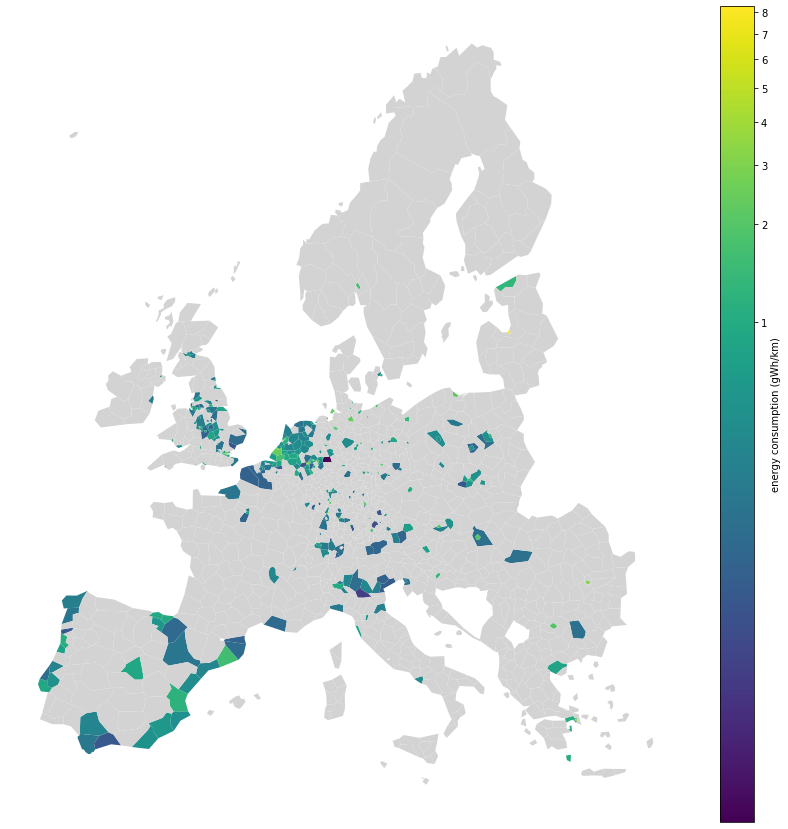

In [37]:
# plotting the top 25% regions div by road km with the highes energy demand in europe
gdf_top_25q_regions_divKm = gdf_dw.join(top_25q_regions_divKm)
gdf_top_25q_regions_divKm = gdf_top_25q_regions_divKm.replace(0, np.nan)

fig, ax = plt.subplots(1, 1, figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax.axis('off')

gdf_top_25q_regions_divKm.plot(column = '2050', 
                                  ax=ax,
                                 legend=True,
                                  cax = cax,
                                  legend_kwds = {'label': 'energy consumption (gWh/km)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.2),
                                 missing_kwds= dict(color = "lightgrey"))

Analysing best regions for CEV

In [39]:
#selecting only energy demand for CEV and summing that demand up by region
idx = pd.IndexSlice
gWh_tot_region_BEV_CEV_CEV = gWh_tot_region_BEV_CEV.loc[idx[:,'CEV'],:]
gWh_tot_region_BEV_CEV_CEV = gWh_tot_region_BEV_CEV_CEV.groupby('id').sum()

In [40]:
# selecting only the motorways to analyse where it would make sense to invest into CEV
motorways = roads_nuts[roads_nuts['COR'] == 1]
motorways_nuts_length = motorways.groupby('id').sum()
motorways_nuts_length_select = motorways_nuts_length.drop(columns=['COAST_TYPE', 'MOUNT_TYPE', 'LEVL_CODE', 'URBN_TYPE', 'index_right', 'FCsubtype', 'COR', 'EXS', 'LLE', 'LTN', 'MED', 'RST', 'RSU', 'RTT', 'TEN', 'TOL', 'TUC', 'SHAPE_Leng'])
motorways_km_select = motorways_nuts_length_select.div(1000)
motorways_km_select = motorways_km_select.rename(columns = {'road_m': 'motorways_km'})

In [41]:
# div energy demand of each region by the km of motorways in each region
gWh_tot_region_BEV_CEV_CEV.columns = gWh_tot_region_BEV_CEV_CEV.columns.astype(str)
gWh_div_motorwaykm_perRegion_CEV = gWh_tot_region_BEV_CEV_CEV[['2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050']].div(motorways_km_select.motorways_km, axis = 0)

<AxesSubplot:>

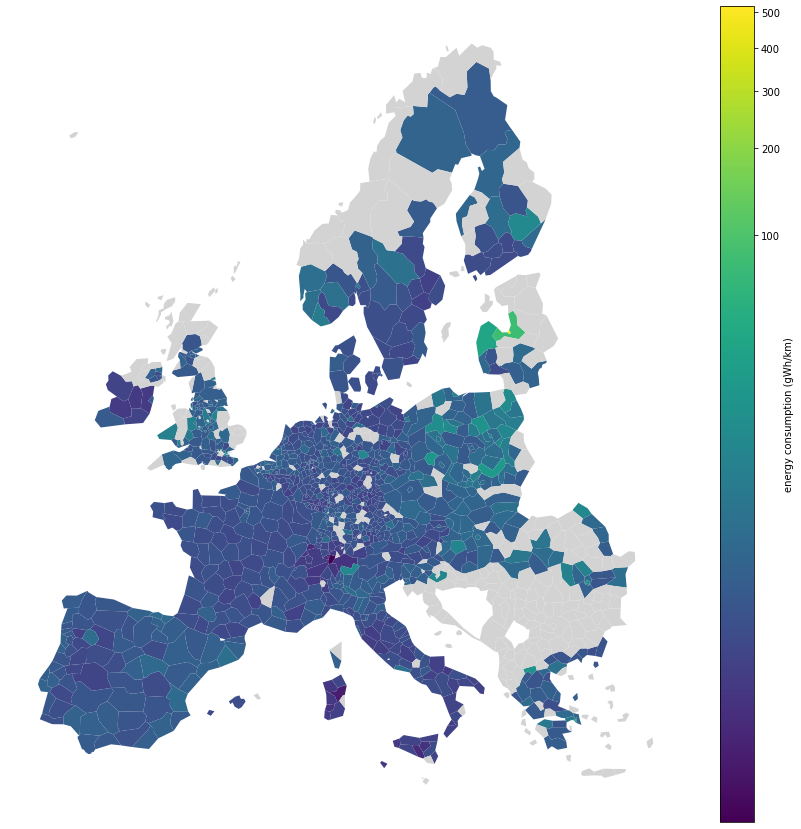

In [42]:
gdf_gWh_div_motorwaykm_perRegion_CEV = gdf_dw.join(gWh_div_motorwaykm_perRegion_CEV)

fig, ax = plt.subplots(1, 1, figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax.axis('off')

gdf_gWh_div_motorwaykm_perRegion_CEV.plot(column = '2050', 
                                  ax=ax,
                                 legend=True,
                                  cax = cax,
                                  legend_kwds = {'label': 'energy consumption (gWh/km)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.2),
                                 missing_kwds= dict(color = "lightgrey"))

In [43]:
#select column 2050 and set it as dataframe
gWh_div_motorwaykm_perRegion_CEV_2050 = gWh_div_motorwaykm_perRegion_CEV.loc[:,'2050']
gWh_div_motorwaykm_perRegion_CEV_2050 = gWh_div_motorwaykm_perRegion_CEV_2050.to_frame(name = '2050')

In [44]:
# calculating 0.9 quantile of df
gWh_div_motorwaykm_perRegion_CEV_2050_q85 = gWh_div_motorwaykm_perRegion_CEV_2050.quantile(q = 0.85)

2050    2.153538
Name: 0.85, dtype: float64

In [45]:
#selecting top 10% regions with highest energy demand per km motorway
top_15p_regions_CEV = gWh_div_motorwaykm_perRegion_CEV_2050[gWh_div_motorwaykm_perRegion_CEV_2050['2050'] > 1.952733]
pd.set_option('display.max_rows', 10)  # or 1000

In [46]:
# calculating 0.75 quantile of df
gWh_div_motorwaykm_perRegion_CEV_2050_q07 = gWh_div_motorwaykm_perRegion_CEV_2050.quantile(q = 0.70)

2050    1.222799
Name: 0.7, dtype: float64

In [47]:
#selecting top 25% regions with highest energy demand per km motorway
top_30p_regions_CEV = gWh_div_motorwaykm_perRegion_CEV_2050[gWh_div_motorwaykm_perRegion_CEV_2050['2050'] > 1.08939]

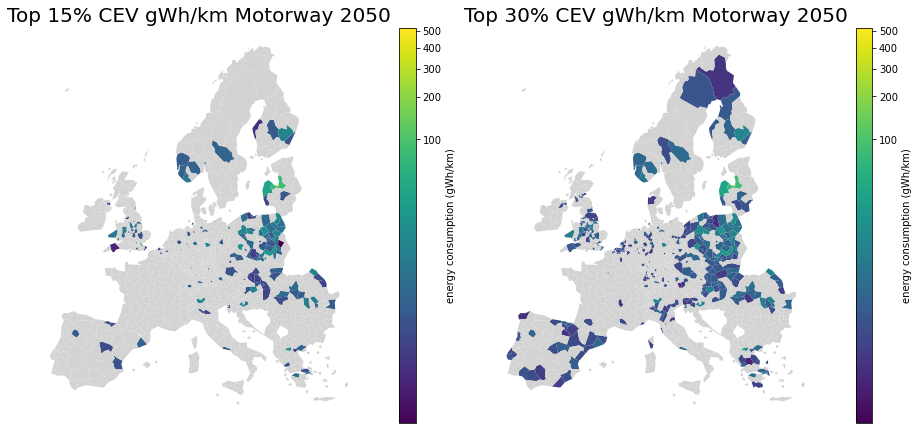

In [48]:
gdf_top_15p_regions_CEV = gdf_dw.join(top_15p_regions_CEV)
gdf_top_30p_regions_CEV = gdf_dw.join(top_30p_regions_CEV)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,15))
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.5)
ax1.axis('off')
ax1.set_title("Top 15% CEV gWh/km Motorway 2050", fontsize=20)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.5)
ax2.axis('off')
ax2.set_title("Top 30% CEV gWh/km Motorway 2050", fontsize=20)

gdf_top_15p_regions_CEV.plot(column = '2050', 
                                  ax=ax1,
                                 legend=True,
                                  cax = cax1,
                                  legend_kwds = {'label': 'energy consumption (gWh/km)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.2),
                                 missing_kwds= dict(color = "lightgrey"))
gdf_top_30p_regions_CEV.plot(column = '2050', 
                                  ax=ax2,
                                 legend=True,
                                  cax = cax2,
                                  legend_kwds = {'label': 'energy consumption (gWh/km)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.2),
                                 missing_kwds= dict(color = "lightgrey")
                            )

fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/CEV_Plot.png")

<AxesSubplot:>

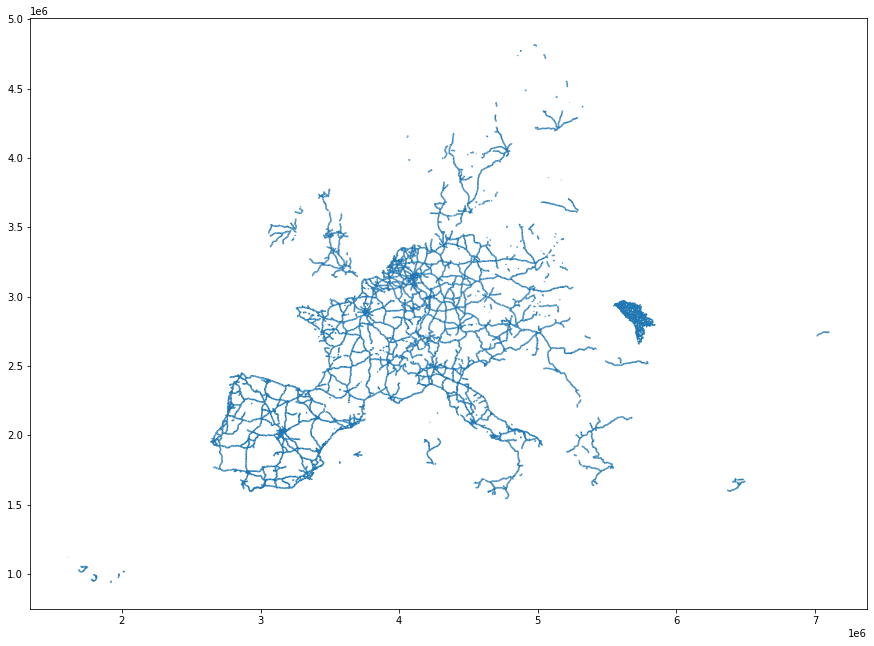

In [49]:
motorways_plot = road_m[road_m['COR'] == 1]
fig, ax = plt.subplots(1, 1, figsize = (15,15))
motorways_plot.plot(ax = ax)

In [50]:
column = gWh_tot_region_tot_BEV_CEV['2050']
max_value = column.max()
gWh_tot_region_tot_BEV_CEV.idxmax()

2020    ES511
2021    ES511
2022    ES511
2023    ES511
2024    ES511
        ...  
2046    ES511
2047    ES511
2048    ES511
2049    ES511
2050    ES511
Length: 31, dtype: object

BEV_FCEV Scenario

In [51]:
powertrain_share_BEV_FCEV = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Scenarios/VSM_Results/VSM_Results_Safe.xlsx', sheet_name = 'BEV_FCEV')
powertrain_share_BEV_FCEV = powertrain_share_BEV_FCEV.set_index(['Lifetime','distance_class','Powertrain'])
pow_share_BEV_FCEV = powertrain_share_BEV_FCEV.drop(index = 'Total', level = 2)
powertrain_share_10y_BEV_FCEV = pow_share_BEV_FCEV.loc['10y']
kWh_tot_BEV_FCEV = kWh_all_powertrains.multiply(powertrain_share_10y_BEV_FCEV)
gWh_tot_BEV_FCEV = kWh_tot_BEV_FCEV.multiply(0.000001)
gWh_Powertrain_BEV_FCEV = gWh_tot_BEV_FCEV.groupby('Powertrain').sum()
gWh_tot_region_BEV_FCEV = gWh_tot_BEV_FCEV.multiply(t_s_NUTS3)
gWh_tot_region_tot_BEV_FCEV = gWh_tot_region_BEV_FCEV.groupby('id').sum()
gdf_gWh_tot_region_tot_BEV_FCEV = gdf_dw.join(gWh_tot_region_tot_BEV_FCEV)
road_km_select.columns = road_km_select.columns.astype(str)
gdf_gWh_tot_region_tot_BEV_FCEV.columns = gdf_gWh_tot_region_tot_BEV_FCEV.columns.astype(str)
gWh_div_roadkm_perRegion_BEV_FCEV = gdf_gWh_tot_region_tot_BEV_FCEV[['2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050']].div(road_km_select.road_km, axis = 0)
gdf_gWh_div_roadkm_perRegion_BEV_FCEV = gdf_dw.join(gWh_div_roadkm_perRegion_BEV_FCEV)

<AxesSubplot:>

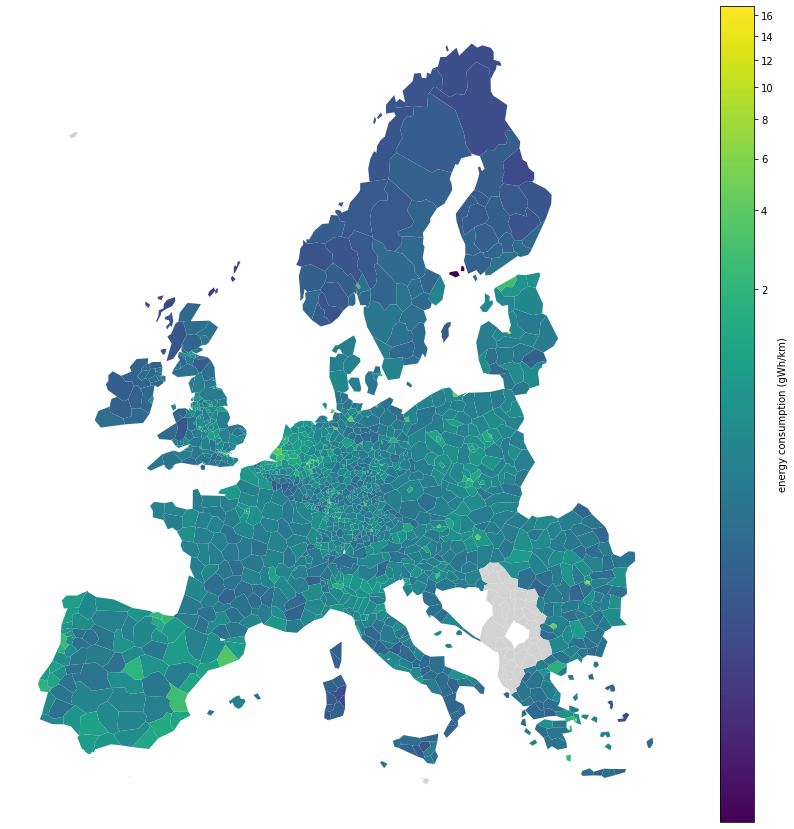

In [53]:
gdf_gWh_div_roadkm_perRegion_BEV_FCEV = gdf_gWh_div_roadkm_perRegion_BEV_FCEV.replace(0, np.nan)

fig, ax = plt.subplots(1, 1, figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax.axis('off')

gdf_gWh_div_roadkm_perRegion_BEV_FCEV.plot(column = '2050', 
                                  ax=ax,
                                 legend=True,
                                  cax = cax,
                                  legend_kwds = {'label': 'energy consumption (gWh/km)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.2),
                                 missing_kwds= dict(color = "lightgrey"))

<AxesSubplot:>

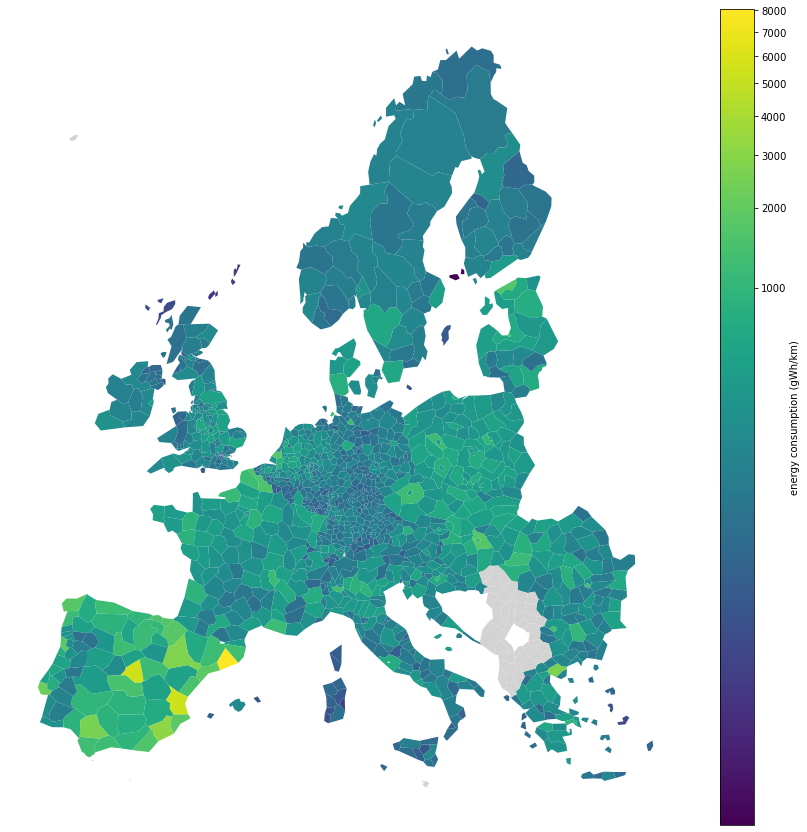

In [54]:
gdf_gWh_tot_region_tot_BEV_FCEV = gdf_gWh_tot_region_tot_BEV_FCEV.replace(0, np.nan)

fig, ax = plt.subplots(1, 1, figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax.axis('off')

gdf_gWh_tot_region_tot_BEV_FCEV.plot(column = '2050', 
                                  ax=ax,
                                 legend=True,
                                  cax = cax,
                                  legend_kwds = {'label': 'energy consumption (gWh/km)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.2),
                                 missing_kwds= dict(color = "lightgrey"))

BEV_SynD_Bio Scenario

In [55]:
powertrain_share_BEV_SynD_Bio = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Scenarios/VSM_Results/VSM_Results_Safe.xlsx', sheet_name = 'BEV_SynD_Bio')
powertrain_share_BEV_SynD_Bio = powertrain_share_BEV_SynD_Bio.set_index(['Lifetime','distance_class','Powertrain'])
pow_share_BEV_SynD_Bio = powertrain_share_BEV_SynD_Bio.drop(index = 'Total', level = 2)
powertrain_share_10y_BEV_SynD_Bio = pow_share_BEV_SynD_Bio.loc['10y']
kWh_tot_BEV_SynD_Bio = kWh_all_powertrains.multiply(powertrain_share_10y_BEV_SynD_Bio)
gWh_tot_BEV_SynD_Bio = kWh_tot_BEV_SynD_Bio.multiply(0.000001)
gWh_Powertrain_BEV_SynD_Bio = gWh_tot_BEV_SynD_Bio.groupby('Powertrain').sum()
gWh_tot_region_BEV_SynD_Bio = gWh_tot_BEV_SynD_Bio.multiply(t_s_NUTS3)
gWh_tot_region_tot_BEV_SynD_Bio = gWh_tot_region_BEV_SynD_Bio.groupby('id').sum()
gdf_gWh_tot_region_tot_BEV_SynD_Bio = gdf_dw.join(gWh_tot_region_tot_BEV_SynD_Bio)
road_km_select.columns = road_km_select.columns.astype(str)
gdf_gWh_tot_region_tot_BEV_SynD_Bio.columns = gdf_gWh_tot_region_tot_BEV_SynD_Bio.columns.astype(str)
gWh_div_roadkm_perRegion_BEV_SynD_Bio = gdf_gWh_tot_region_tot_BEV_SynD_Bio[['2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050']].div(road_km_select.road_km, axis = 0)
gdf_gWh_div_roadkm_perRegion_BEV_SynD_Bio = gdf_dw.join(gWh_div_roadkm_perRegion_BEV_SynD_Bio)

<AxesSubplot:>

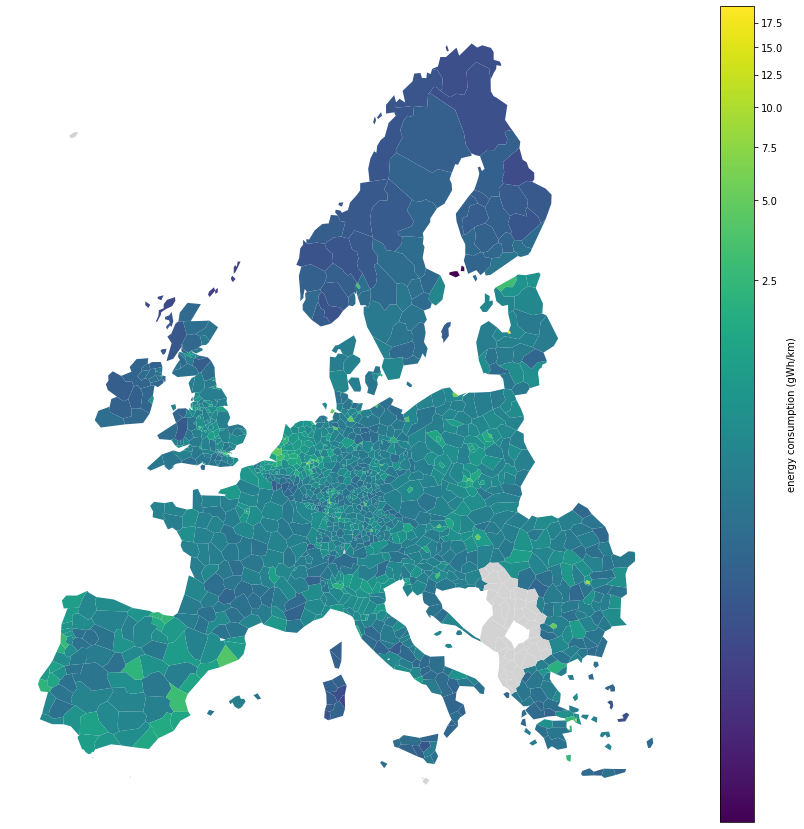

In [56]:
gdf_gWh_div_roadkm_perRegion_BEV_SynD_Bio = gdf_gWh_div_roadkm_perRegion_BEV_SynD_Bio.replace(0, np.nan)

fig, ax = plt.subplots(1, 1, figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax.axis('off')

gdf_gWh_div_roadkm_perRegion_BEV_SynD_Bio.plot(column = '2050', 
                                  ax=ax,
                                 legend=True,
                                  cax = cax,
                                  legend_kwds = {'label': 'energy consumption (gWh/km)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.2),
                                 missing_kwds= dict(color = "lightgrey"))

<AxesSubplot:>

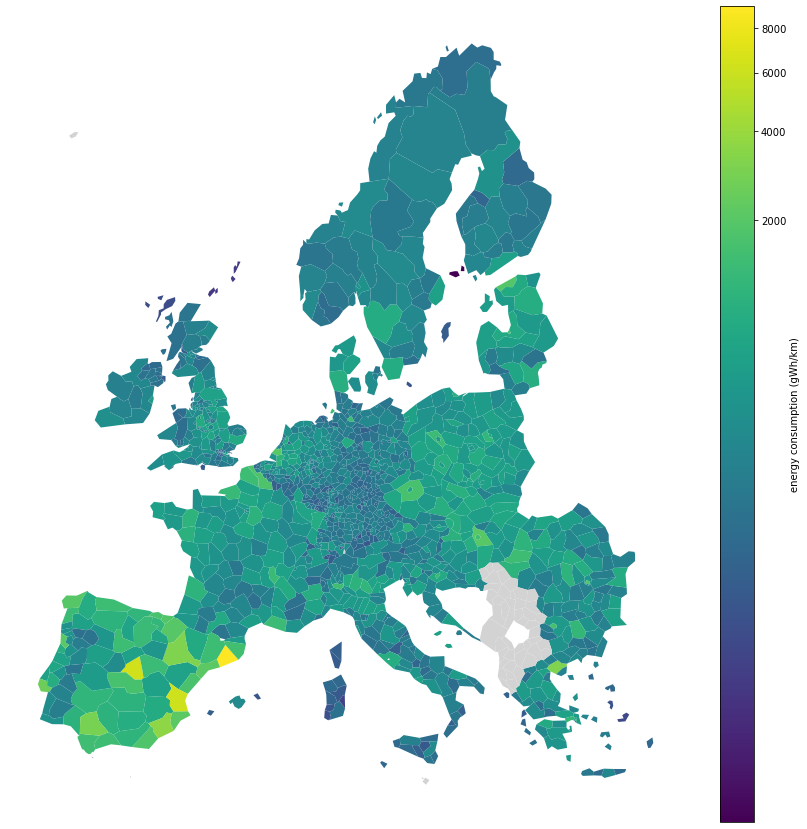

In [57]:
gdf_gWh_tot_region_tot_BEV_SynD_Bio = gdf_gWh_tot_region_tot_BEV_SynD_Bio.replace(0, np.nan)

fig, ax = plt.subplots(1, 1, figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax.axis('off')

gdf_gWh_tot_region_tot_BEV_SynD_Bio.plot(column = '2050', 
                                  ax=ax,
                                 legend=True,
                                  cax = cax,
                                  legend_kwds = {'label': 'energy consumption (gWh/km)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.2),
                                 missing_kwds= dict(color = "lightgrey"))

BEV_NG_SynG Scenario

In [58]:
powertrain_share_BEV_NG_SynG = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Scenarios/VSM_Results/VSM_Results_Safe.xlsx', sheet_name = 'BEV_NG_SynG')
powertrain_share_BEV_NG_SynG = powertrain_share_BEV_NG_SynG.set_index(['Lifetime','distance_class','Powertrain'])
pow_share_BEV_NG_SynG = powertrain_share_BEV_NG_SynG.drop(index = 'Total', level = 2)
powertrain_share_10y_BEV_NG_SynG = pow_share_BEV_NG_SynG.loc['10y']
kWh_tot_BEV_NG_SynG = kWh_all_powertrains.multiply(powertrain_share_10y_BEV_NG_SynG)
gWh_tot_BEV_NG_SynG = kWh_tot_BEV_NG_SynG.multiply(0.000001)
gWh_Powertrain_BEV_NG_SynG = gWh_tot_BEV_NG_SynG.groupby('Powertrain').sum()
gWh_tot_region_BEV_NG_SynG = gWh_tot_BEV_NG_SynG.multiply(t_s_NUTS3)
gWh_tot_region_tot_BEV_NG_SynG = gWh_tot_region_BEV_NG_SynG.groupby('id').sum()
gdf_gWh_tot_region_tot_BEV_NG_SynG = gdf_dw.join(gWh_tot_region_tot_BEV_NG_SynG)
road_km_select.columns = road_km_select.columns.astype(str)
gdf_gWh_tot_region_tot_BEV_NG_SynG.columns = gdf_gWh_tot_region_tot_BEV_NG_SynG.columns.astype(str)
gWh_div_roadkm_perRegion_BEV_NG_SynG = gdf_gWh_tot_region_tot_BEV_NG_SynG[['2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050']].div(road_km_select.road_km, axis = 0)
gdf_gWh_div_roadkm_perRegion_BEV_NG_SynG = gdf_dw.join(gWh_div_roadkm_perRegion_BEV_NG_SynG)

FCEV_Scenario

In [59]:
powertrain_share_FCEV = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Scenarios/VSM_Results/VSM_Results_Safe.xlsx', sheet_name = 'FCEV')
powertrain_share_FCEV = powertrain_share_FCEV.set_index(['Lifetime','distance_class','Powertrain'])
pow_share_FCEV = powertrain_share_FCEV.drop(index = 'Total', level = 2)
powertrain_share_10y_FCEV = pow_share_FCEV.loc['10y']
kWh_tot_FCEV = kWh_all_powertrains.multiply(powertrain_share_10y_FCEV)
gWh_tot_FCEV = kWh_tot_FCEV.multiply(0.000001)
gWh_Powertrain_FCEV = gWh_tot_FCEV.groupby('Powertrain').sum()
gWh_tot_region_FCEV = gWh_tot_FCEV.multiply(t_s_NUTS3)
gWh_tot_region_tot_FCEV = gWh_tot_region_FCEV.groupby('id').sum()
gdf_gWh_tot_region_tot_FCEV = gdf_dw.join(gWh_tot_region_tot_FCEV)
road_km_select.columns = road_km_select.columns.astype(str)
gdf_gWh_tot_region_tot_FCEV.columns = gdf_gWh_tot_region_tot_FCEV.columns.astype(str)
gWh_div_roadkm_perRegion_FCEV = gdf_gWh_tot_region_tot_FCEV[['2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050']].div(road_km_select.road_km, axis = 0)
gdf_gWh_div_roadkm_perRegion_FCEV = gdf_dw.join(gWh_div_roadkm_perRegion_FCEV)

BEV_Scenario

In [60]:
powertrain_share_BEV = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Scenarios/VSM_Results/VSM_Results_Safe.xlsx', sheet_name = 'BEV')
powertrain_share_BEV = powertrain_share_BEV.set_index(['Lifetime','distance_class','Powertrain'])
pow_share_BEV = powertrain_share_BEV.drop(index = 'Total', level = 2)
powertrain_share_10y_BEV = pow_share_BEV.loc['10y']
kWh_tot_BEV = kWh_all_powertrains.multiply(powertrain_share_10y_BEV)
gWh_tot_BEV = kWh_tot_BEV.multiply(0.000001)
gWh_Powertrain_BEV = gWh_tot_BEV.groupby('Powertrain').sum()
gWh_tot_region_BEV = gWh_tot_BEV.multiply(t_s_NUTS3)
gWh_tot_region_tot_BEV = gWh_tot_region_BEV.groupby('id').sum()
gdf_gWh_tot_region_tot_BEV = gdf_dw.join(gWh_tot_region_tot_BEV)
road_km_select.columns = road_km_select.columns.astype(str)
gdf_gWh_tot_region_tot_BEV.columns = gdf_gWh_tot_region_tot_BEV.columns.astype(str)
gWh_div_roadkm_perRegion_BEV = gdf_gWh_tot_region_tot_BEV[['2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050']].div(road_km_select.road_km, axis = 0)
gdf_gWh_div_roadkm_perRegion_BEV = gdf_dw.join(gWh_div_roadkm_perRegion_BEV)

Syn.Meth_Scenario

In [61]:
powertrain_share_Syn_Meth = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Scenarios/VSM_Results/VSM_Results_Safe.xlsx', sheet_name = 'Syn.Meth')
powertrain_share_Syn_Meth = powertrain_share_Syn_Meth.set_index(['Lifetime','distance_class','Powertrain'])
pow_share_Syn_Meth = powertrain_share_Syn_Meth.drop(index = 'Total', level = 2)
powertrain_share_10y_Syn_Meth = pow_share_Syn_Meth.loc['10y']
kWh_tot_Syn_Meth = kWh_all_powertrains.multiply(powertrain_share_10y_Syn_Meth)
gWh_tot_Syn_Meth = kWh_tot_Syn_Meth.multiply(0.000001)
gWh_Powertrain_Syn_Meth = gWh_tot_Syn_Meth.groupby('Powertrain').sum()
gWh_tot_region_Syn_Meth = gWh_tot_Syn_Meth.multiply(t_s_NUTS3)
gWh_tot_region_tot_Syn_Meth = gWh_tot_region_Syn_Meth.groupby('id').sum()
gdf_gWh_tot_region_tot_Syn_Meth = gdf_dw.join(gWh_tot_region_tot_Syn_Meth)
road_km_select.columns = road_km_select.columns.astype(str)
gdf_gWh_tot_region_tot_Syn_Meth.columns = gdf_gWh_tot_region_tot_Syn_Meth.columns.astype(str)
gWh_div_roadkm_perRegion_Syn_Meth = gdf_gWh_tot_region_tot_Syn_Meth[['2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050']].div(road_km_select.road_km, axis = 0)
gdf_gWh_div_roadkm_perRegion_Syn_Meth = gdf_dw.join(gWh_div_roadkm_perRegion_Syn_Meth)

Bio-,SynDiesel

In [62]:
powertrain_share_Bio_Syn_Diesel = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Scenarios/VSM_Results/VSM_Results_Safe.xlsx', sheet_name = 'Bio-,SynDiesel')
powertrain_share_Bio_Syn_Diesel = powertrain_share_Bio_Syn_Diesel.set_index(['Lifetime','distance_class','Powertrain'])
pow_share_Bio_Syn_Diesel = powertrain_share_Bio_Syn_Diesel.drop(index = 'Total', level = 2)
powertrain_share_10y_Bio_Syn_Diesel = pow_share_Bio_Syn_Diesel.loc['10y']
kWh_tot_Bio_Syn_Diesel = kWh_all_powertrains.multiply(powertrain_share_10y_Bio_Syn_Diesel)
gWh_tot_Bio_Syn_Diesel = kWh_tot_Bio_Syn_Diesel.multiply(0.000001)
gWh_Powertrain_Bio_Syn_Diesel = gWh_tot_Bio_Syn_Diesel.groupby('Powertrain').sum()
gWh_tot_region_Bio_Syn_Diesel = gWh_tot_Bio_Syn_Diesel.multiply(t_s_NUTS3)
gWh_tot_region_tot_Bio_Syn_Diesel = gWh_tot_region_Bio_Syn_Diesel.groupby('id').sum()
gdf_gWh_tot_region_tot_Bio_Syn_Diesel = gdf_dw.join(gWh_tot_region_tot_Bio_Syn_Diesel)
road_km_select.columns = road_km_select.columns.astype(str)
gdf_gWh_tot_region_tot_Bio_Syn_Diesel.columns = gdf_gWh_tot_region_tot_Bio_Syn_Diesel.columns.astype(str)
gWh_div_roadkm_perRegion_Bio_Syn_Diesel = gdf_gWh_tot_region_tot_Bio_Syn_Diesel[['2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050']].div(road_km_select.road_km, axis = 0)
gdf_gWh_div_roadkm_perRegion_Bio_Syn_Diesel = gdf_dw.join(gWh_div_roadkm_perRegion_Bio_Syn_Diesel)

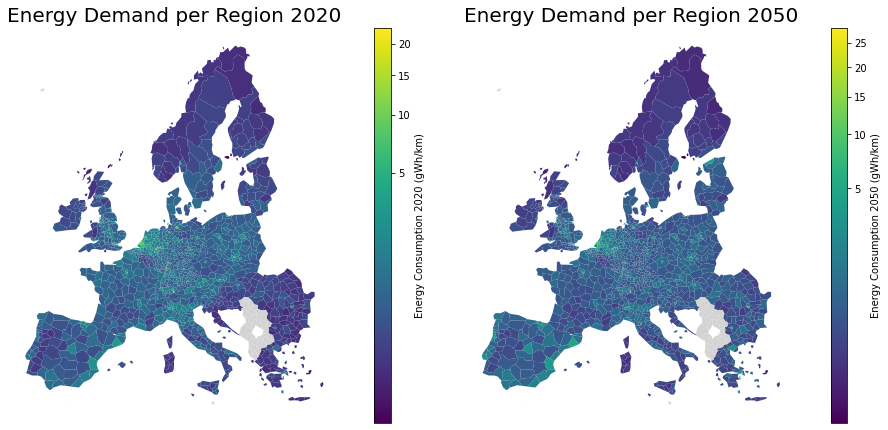

In [63]:
# Plot results
gdf_gWh_div_roadkm_perRegion_Bio_Syn_Diesel = gdf_gWh_div_roadkm_perRegion_Bio_Syn_Diesel.replace(0, np.nan)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,15))
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.5)
ax1.axis('off')
ax1.set_title("Energy Demand per Region 2020", fontsize=20)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.5)
ax2.axis('off')
ax2.set_title("Energy Demand per Region 2050", fontsize=20)

gdf_gWh_div_roadkm_perRegion_Bio_Syn_Diesel.plot(column = '2020', 
                                  ax=ax1,
                                 legend=True,
                                  cax = cax1,
                                  legend_kwds = {'label': 'Energy Consumption 2020 (gWh/km)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.3),
                                 missing_kwds= dict(color = "lightgrey"))
gdf_gWh_div_roadkm_perRegion_Bio_Syn_Diesel.plot(column = '2050', 
                                  ax=ax2,
                                 legend=True,
                                  cax = cax2,
                                  legend_kwds = {'label': 'Energy Consumption 2050 (gWh/km)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.3),
                                 missing_kwds= dict(color = "lightgrey"))

fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/gWh_div_roadkm_new.png")

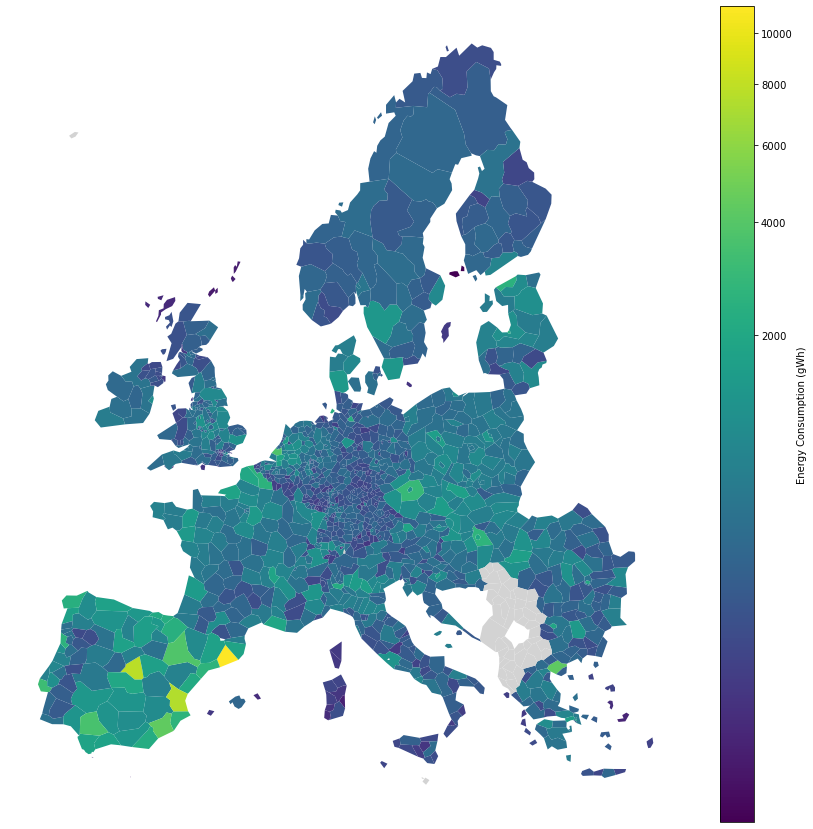

In [64]:
gdf_gWh_tot_region_tot_Bio_Syn_Diesel = gdf_gWh_tot_region_tot_Bio_Syn_Diesel.replace(0, np.nan)

fig, ax = plt.subplots(1, 1, figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax.axis('off')

gdf_gWh_tot_region_tot_Bio_Syn_Diesel.plot(column = '2050', 
                                  ax=ax,
                                 legend=True,
                                  cax = cax,
                                  legend_kwds = {'label': 'Energy Consumption (gWh)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.3),
                                 missing_kwds= dict(color = "lightgrey"))

fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/gWh_new.png")

# Plots Summary of multiple Scenarios

In [66]:
#Plot total energy demand of vehicle fleet of each scenario
gWh_Powertrain_BEV_FCEV.columns = gWh_Powertrain_BEV_FCEV.columns.astype(str)
gWh_Powertrain_plot_BEV_FCEV = gWh_Powertrain_BEV_FCEV.loc[['BEV', 'Diesel ', 'CNG', 'LNG', 'Diesel HEV', 'FCEV'], ['2020', '2030', '2040', '2050']]
gWh_Powertrain_plot_BEV_FCEV.loc['BEV_FCEV',:]= gWh_Powertrain_plot_BEV_FCEV.sum(axis=0)
gWh_plot_BEV_FCEV = gWh_Powertrain_plot_BEV_FCEV.drop(['BEV', 'Diesel ','CNG', 'LNG', 'Diesel HEV', 'FCEV'])
gWh_plot_BEV_FCEV.index.names = ['Scenario']

gWh_Powertrain_BEV_CEV.columns = gWh_Powertrain_BEV_CEV.columns.astype(str)
gWh_Powertrain_plot_BEV_CEV = gWh_Powertrain_BEV_CEV.loc[['BEV', 'Diesel ','CNG', 'LNG', 'Diesel HEV', 'CEV'], ['2020', '2030', '2040', '2050']]
gWh_Powertrain_plot_BEV_CEV.loc['BEV_CEV',:]= gWh_Powertrain_plot_BEV_CEV.sum(axis=0)
gWh_plot_BEV_CEV = gWh_Powertrain_plot_BEV_CEV.drop(['BEV', 'Diesel ','CNG', 'LNG', 'Diesel HEV', 'CEV'])
gWh_plot_BEV_CEV.index.names = ['Scenario']

gWh_Powertrain_BEV_SynD_Bio.columns = gWh_Powertrain_BEV_SynD_Bio.columns.astype(str)
gWh_Powertrain_plot_BEV_SynD_Bio = gWh_Powertrain_BEV_SynD_Bio.loc[['Diesel ','CNG', 'LNG', 'Biofuel' , 'Diesel HEV', 'Biofuel HEV', 'Synthetic Diesel HEV', 'BEV'], ['2020', '2030', '2040', '2050']]
gWh_Powertrain_plot_BEV_SynD_Bio.loc['BEV_SynD_Bio',:]= gWh_Powertrain_plot_BEV_SynD_Bio.sum(axis=0)
gWh_plot_BEV_SynD_Bio = gWh_Powertrain_plot_BEV_SynD_Bio.drop(['Diesel ','CNG', 'LNG', 'Biofuel', 'Diesel HEV', 'Biofuel HEV', 'Synthetic Diesel HEV', 'BEV'])
gWh_plot_BEV_SynD_Bio.index.names = ['Scenario']

gWh_Powertrain_BEV_NG_SynG.columns = gWh_Powertrain_BEV_NG_SynG.columns.astype(str)
gWh_Powertrain_plot_BEV_NG_SynG = gWh_Powertrain_BEV_NG_SynG.loc[['Diesel ','CNG', 'LNG', 'Diesel HEV', 'LNG HEV', 'CNG HEV', 'BEV', 'Synthetic Methane HEV'], ['2020', '2030', '2040', '2050']]
gWh_Powertrain_plot_BEV_NG_SynG.loc['BEV_NG_SynG',:]= gWh_Powertrain_plot_BEV_NG_SynG.sum(axis=0)
gWh_plot_BEV_NG_SynG = gWh_Powertrain_plot_BEV_NG_SynG.drop(['Diesel ','CNG', 'LNG', 'Diesel HEV', 'LNG HEV', 'CNG HEV', 'BEV', 'Synthetic Methane HEV'])
gWh_plot_BEV_NG_SynG.index.names = ['Scenario']

In [67]:
gWh_Scenarios = pd.concat((gWh_plot_BEV_CEV, gWh_plot_BEV_FCEV, gWh_plot_BEV_SynD_Bio, gWh_plot_BEV_NG_SynG))

2020           2030           2040           2050
Scenario                                                                
BEV_CEV       529855.846617  441541.026005  266672.266678  212747.316256
BEV_FCEV      529855.846617  443134.816604  384961.287426  411875.085445
BEV_SynD_Bio  529855.846617  444797.595443  430641.075449  481912.754068
BEV_NG_SynG   528208.148628  474773.201572  524846.642159  597474.424108

<AxesSubplot:>

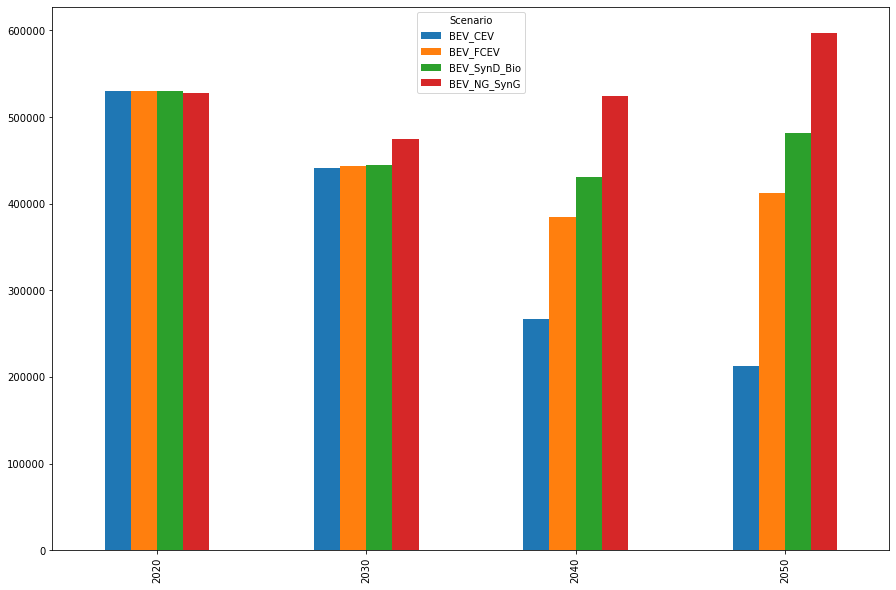

In [68]:
fig, ax = plt.subplots(1, 1, figsize = (15,10))
gWh_Scenarios.T.plot(kind = 'bar', ax = ax)
#show portion of biofuels and etc in each bar

# Stacked Bar Plot Total Energy demand of each scenario

In [69]:
#Stacked Bar Plot total energy demand of vehicle fleet of each scenario fuel /powertrain share
gWh_Powertrain_BEV_FCEV.columns = gWh_Powertrain_BEV_FCEV.columns.astype(str)
gWh_Powertrain_stackedplot_BEV_FCEV = gWh_Powertrain_BEV_FCEV.loc[['Diesel ', 'Diesel HEV', 'BEV', 'FCEV'], ['2020', '2030', '2040', '2050']]

gWh_Powertrain_BEV_CEV.columns = gWh_Powertrain_BEV_CEV.columns.astype(str)
gWh_Powertrain_stackedplot_BEV_CEV = gWh_Powertrain_BEV_CEV.loc[['Diesel ', 'Diesel HEV', 'BEV', 'CEV'], ['2020', '2030', '2040', '2050']]

gWh_Powertrain_BEV_SynD_Bio.columns = gWh_Powertrain_BEV_SynD_Bio.columns.astype(str)
gWh_Powertrain_stackedplot_BEV_SynD_Bio = gWh_Powertrain_BEV_SynD_Bio.loc[['Diesel ', 'Diesel HEV', 'Biofuel' ,'Biofuel HEV', 'BEV', 'Synthetic Diesel HEV'], ['2020', '2030', '2040', '2050']]

gWh_Powertrain_BEV_NG_SynG.columns = gWh_Powertrain_BEV_NG_SynG.columns.astype(str)
gWh_Powertrain_stackedplot_BEV_NG_SynG = gWh_Powertrain_BEV_NG_SynG.loc[['Diesel ', 'Diesel HEV','CNG', 'LNG', 'LNG HEV', 'CNG HEV', 'BEV', 'Synthetic Methane HEV'], ['2020', '2030', '2040', '2050']]

gWh_Powertrain_Bio_Syn_Diesel.columns = gWh_Powertrain_Bio_Syn_Diesel.columns.astype(str)
gWh_Powertrain_stackedplot_Bio_Syn_Diesel = gWh_Powertrain_Bio_Syn_Diesel.loc[['Diesel ','Diesel HEV', 'Biofuel' ,'Biofuel HEV', 'Synthetic Diesel HEV'], ['2020', '2030', '2040', '2050']]

gWh_Powertrain_Syn_Meth.columns = gWh_Powertrain_Syn_Meth.columns.astype(str)
gWh_Powertrain_stackedplot_Syn_Meth = gWh_Powertrain_Syn_Meth.loc[['Diesel ', 'Diesel HEV', 'CNG', 'LNG',  'LNG HEV', 'CNG HEV', 'Synthetic Methane HEV'], ['2020', '2030', '2040', '2050']]

gWh_Powertrain_FCEV.columns = gWh_Powertrain_FCEV.columns.astype(str)
gWh_Powertrain_stackedplot_FCEV = gWh_Powertrain_FCEV.loc[['Diesel ','Diesel HEV', 'FCEV'], ['2020', '2030', '2040', '2050']]

In [70]:
gWh_Powertrain_stackedplot_BEV_FCEV.insert(loc=0, column='Scenario', value='BEV, FCEV')
gWh_Powertrain_stackedplot_BEV_CEV.insert(loc=0, column='Scenario', value='BEV, CEV')
gWh_Powertrain_stackedplot_BEV_SynD_Bio.insert(loc=0, column='Scenario', value='BEV, Syn_D, Bio_D')
gWh_Powertrain_stackedplot_BEV_NG_SynG.insert(loc=0, column='Scenario', value='BEV, Syn_G, NG')
gWh_Powertrain_stackedplot_Bio_Syn_Diesel.insert(loc=0, column='Scenario', value='Syn_D, Bio_D')
gWh_Powertrain_stackedplot_Syn_Meth.insert(loc=0, column='Scenario', value='_Syn_G')
gWh_Powertrain_stackedplot_FCEV.insert(loc=0, column='Scenario', value='FCEV')

In [71]:
gWh_Powertrain_stackedplot_BEV_FCEV = gWh_Powertrain_stackedplot_BEV_FCEV.reset_index()
gWh_Powertrain_stackedplot_BEV_CEV = gWh_Powertrain_stackedplot_BEV_CEV.reset_index()
gWh_Powertrain_stackedplot_BEV_SynD_Bio = gWh_Powertrain_stackedplot_BEV_SynD_Bio.reset_index()
gWh_Powertrain_stackedplot_BEV_NG_SynG = gWh_Powertrain_stackedplot_BEV_NG_SynG.reset_index()
gWh_Powertrain_stackedplot_Bio_Syn_Diesel = gWh_Powertrain_stackedplot_Bio_Syn_Diesel.reset_index()
gWh_Powertrain_stackedplot_Syn_Meth = gWh_Powertrain_stackedplot_Syn_Meth.reset_index()
gWh_Powertrain_stackedplot_FCEV = gWh_Powertrain_stackedplot_FCEV.reset_index()

In [72]:
gWh_Powertrain_stackedplot_BEV_FCEV.set_index(['Scenario','Powertrain'])
gWh_Powertrain_stackedplot_BEV_CEV.set_index(['Scenario','Powertrain'])
gWh_Powertrain_stackedplot_BEV_SynD_Bio.set_index(['Scenario','Powertrain'])
gWh_Powertrain_stackedplot_BEV_NG_SynG.set_index(['Scenario','Powertrain'])
gWh_Powertrain_stackedplot_Bio_Syn_Diesel.set_index(['Scenario','Powertrain'])
gWh_Powertrain_stackedplot_Syn_Meth.set_index(['Scenario','Powertrain'])
gWh_Powertrain_stackedplot_FCEV.set_index(['Scenario','Powertrain'])

2020           2030           2040  \
Scenario Powertrain                                                
FCEV     Diesel      508307.076378  249467.372990       0.000000   
         Diesel HEV    2295.307627  191244.401195  148374.705907   
         FCEV             0.000000    3229.515530  307132.867419   

                              2050  
Scenario Powertrain                 
FCEV     Diesel           0.000000  
         Diesel HEV       9.724562  
         FCEV        528421.063518

In [73]:
gWh_stackedplot_Scenarios = pd.concat((gWh_Powertrain_stackedplot_BEV_FCEV, gWh_Powertrain_stackedplot_BEV_CEV, gWh_Powertrain_stackedplot_BEV_SynD_Bio, gWh_Powertrain_stackedplot_BEV_NG_SynG, gWh_Powertrain_stackedplot_Bio_Syn_Diesel, gWh_Powertrain_stackedplot_Syn_Meth, gWh_Powertrain_stackedplot_FCEV))
gWh_stackedplot_Scenarios_stacked = (gWh_stackedplot_Scenarios
                                 .set_index(['Scenario','Powertrain'])
                                 .stack()
                                 .reset_index()
                                 .rename(columns={'level_2':'Year',0:'gWh'}))


In [74]:
gWh_stackedplot = gWh_stackedplot_Scenarios_stacked.pivot(index=['Year', 'Scenario'], columns = 'Powertrain', values = 'gWh')
gWh_stackedplot_2020 = gWh_stackedplot.loc[('2020', 'BEV, FCEV')]
gWh_stackedplot_2020 = gWh_stackedplot_2020.to_frame()
gWh_stackedplot_2020 = gWh_stackedplot_2020.transpose()
gWh_stackedplot_2020 = gWh_stackedplot_2020.loc['2020']
gWh_stackedplot_2020 = gWh_stackedplot_2020.rename(index = {'BEV, FCEV': 'Starting Point'})

gWh_stackedplot_2030 = gWh_stackedplot.loc[('2030')]
gWh_stackedplot_2040 = gWh_stackedplot.loc[('2040')]
gWh_stackedplot_2050 = gWh_stackedplot.loc[('2050')]
gWh_stackedplot_2030 = gWh_stackedplot_2030.rename_axis(index={'Scenario': '2030'})
gWh_stackedplot_2040 = gWh_stackedplot_2040.rename_axis(index={'Scenario': '2040'})
gWh_stackedplot_2050 = gWh_stackedplot_2050.rename_axis(index={'Scenario': '2050'})

tWh_stackedplot_2020 = gWh_stackedplot_2020.div(1000)
tWh_stackedplot_2030 = gWh_stackedplot_2030.div(1000)
tWh_stackedplot_2040 = gWh_stackedplot_2040.div(1000)
tWh_stackedplot_2050 = gWh_stackedplot_2050.div(1000)

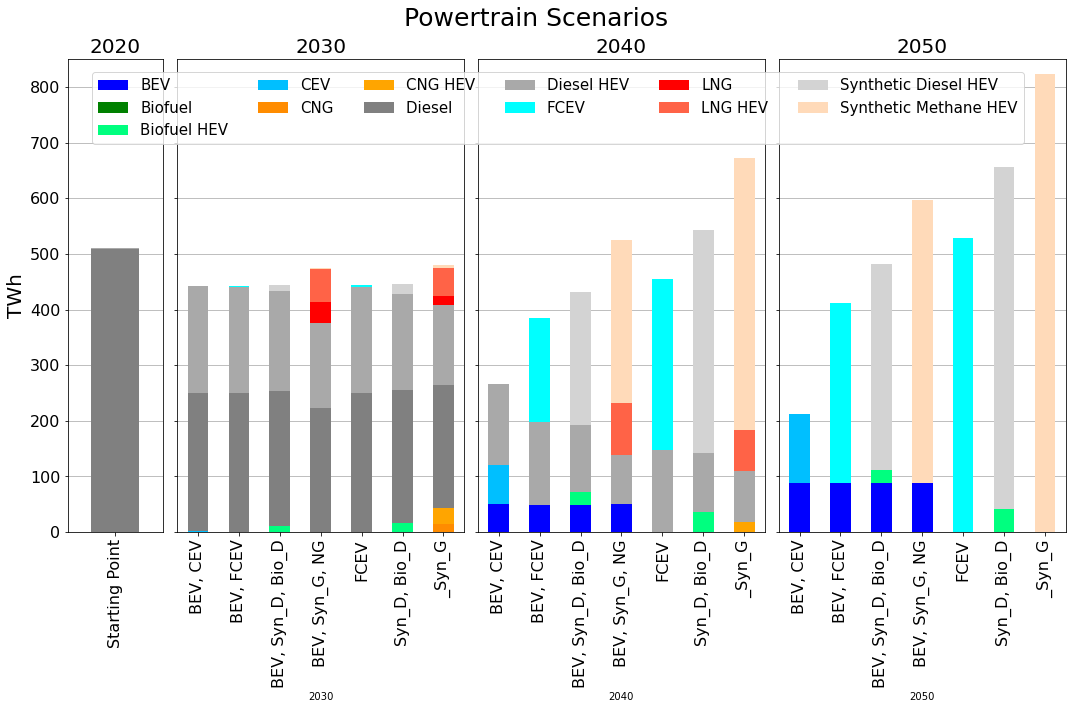

In [76]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 10), gridspec_kw={'width_ratios': [1, 3, 3, 3]})


tWh_stackedplot_2020.plot(kind="bar",
                     stacked=True, 
                     ax = ax1,
                    color = {"Diesel ": "grey", "Diesel HEV": "darkgrey", "BEV": "blue", "Biofuel": "green", "Biofuel HEV": "springgreen", "CEV": "deepskyblue", 
                            "CNG": "darkorange", "CNG HEV": "orange", "FCEV": "cyan", "LNG": "red", "LNG HEV": "tomato",
                             "Synthetic Diesel HEV": "lightgrey", "Synthetic Methane HEV": "peachpuff"},
                     #cmap = 'tab20b',
                    legend = False,
                    zorder=3,
                    fontsize = 16)
tWh_stackedplot_2030.plot(kind="bar",
                     stacked=True, 
                     ax = ax2, 
                    color = {"Diesel ": "grey", "Diesel HEV": "darkgrey", "BEV": "blue", "Biofuel": "green", "Biofuel HEV": "springgreen", "CEV": "deepskyblue", 
                            "CNG": "darkorange", "CNG HEV": "orange", "FCEV": "cyan", "LNG": "red", "LNG HEV": "tomato",
                             "Synthetic Diesel HEV": "lightgrey", "Synthetic Methane HEV": "peachpuff"},
                     #cmap = 'tab20b',
                    legend = False,
                    zorder=3,
                    fontsize = 16)
tWh_stackedplot_2040.plot(kind="bar",
                     stacked=True, 
                     ax = ax3,
                     color = {"Diesel ": "grey", "Diesel HEV": "darkgrey", "BEV": "blue", "Biofuel": "green", "Biofuel HEV": "springgreen", "CEV": "deepskyblue", 
                            "CNG": "darkorange", "CNG HEV": "orange", "FCEV": "cyan", "LNG": "red", "LNG HEV": "tomato",
                             "Synthetic Diesel HEV": "lightgrey", "Synthetic Methane HEV": "peachpuff"},
                     #cmap = 'tab20b',
                    legend = False,
                    zorder=3,
                    fontsize = 16)
tWh_stackedplot_2050.plot(kind="bar",
                     stacked=True, 
                     ax = ax4,
                    color = {"Diesel ": "grey", "Diesel HEV": "darkgrey", "BEV": "blue", "Biofuel": "green", "Biofuel HEV": "springgreen", "CEV": "deepskyblue", 
                            "CNG": "darkorange", "CNG HEV": "orange", "FCEV": "cyan", "LNG": "red", "LNG HEV": "tomato",
                             "Synthetic Diesel HEV": "lightgrey", "Synthetic Methane HEV": "peachpuff"},
                    #cmap = 'tab20b',
                    zorder=3,
                    fontsize = 16,
                    legend = False)

plt.tight_layout()
ax1.set_ylim(0,850)
ax2.set_ylim(0,850)
ax3.set_ylim(0,850)
ax4.set_ylim(0,850)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax1.grid(axis='y', zorder=0)
ax2.grid(axis='y', zorder=0)
ax3.grid(axis='y', zorder=0)
ax4.grid(axis='y', zorder=0)
ax1.set_title("2020", fontsize=20)
ax2.set_title("2030", fontsize=20)
ax3.set_title("2040", fontsize=20)
ax4.set_title("2050", fontsize=20)
ax1.set_ylabel("TWh", fontsize=20)


#ax2.legend(loc=2, prop={'size': 12}, ncol = 2)
fig.suptitle('Powertrain Scenarios', fontsize=25)
#ax4.legend(bbox_to_anchor=(1.0, 1.0), prop={'size': 10}, fontsize=10)
legend_labels = ["BEV", "Biofuel", "Biofuel HEV", "CEV", "CNG", "CNG HEV", 
                            "Diesel ", "Diesel HEV", "FCEV", "LNG", "LNG HEV",
                             "Synthetic Diesel HEV", "Synthetic Methane HEV"]


plt.figlegend(labels = legend_labels, loc = 'upper center', bbox_to_anchor=(0.52, 0.9), ncol = 6, prop={'size': 15})


plt.tight_layout()


fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/stacked_plot.png")

# Show Scenario Choice on Country Level

In [77]:
# Load gdf of Countries
gdf_countries = gpd.read_file('https://gisco-services.ec.europa.eu/distribution/v2/countries/geojson/CNTR_RG_01M_2016_3035.geojson')

In [78]:
#calculate total energy demand for each country for that scenario and select year 2050 and join the two scenarios into one df
gWh_Country_Bio_Syn_Diesel = gWh_tot_Bio_Syn_Diesel.groupby('country').sum()
gWh_Country_Bio_Syn_Diesel_2050 = gWh_Country_Bio_Syn_Diesel.loc[:,2050]
gWh_Country_Bio_Syn_Diesel_2050 = gWh_Country_Bio_Syn_Diesel_2050.to_frame(name = '2050_BS')
gWh_Country_BEV_CEV = gWh_tot_BEV_CEV.groupby('country').sum()
gWh_Country_BEV_CEV_2050 = gWh_Country_BEV_CEV.loc[:,2050]
gWh_Country_BEV_CEV_2050 = gWh_Country_BEV_CEV_2050.to_frame(name = '2050_BC')
gdf_countries_BS_BC = gWh_Country_Bio_Syn_Diesel_2050.join(gWh_Country_BEV_CEV_2050)

In [79]:
#change column titel to same titel in df
gdf_countries = gdf_countries.rename(columns = {'CNTR_ID': 'country'})
#set country column as index
gdf_countries = gdf_countries.set_index('country')
#join gdf with energy demand for scenario of country
gdf_countries_BS_BS = gdf_countries.join(gdf_countries_BS_BC)


In [80]:
#drop all rows with missing values
#gdf_countries_BS_BS = gdf_countries_BS_BS.dropna(axis=0)
#gdf_countries_BS_BS

In [81]:
# Create a custom polygon
polygon = Polygon([(6000000, 1300000), (6000000, 5500000), (2500000, 5500000), (2500000, 1300000), (6000000, 1300000)])
#1. unten rechts, 2. oben rechts, 3. oben links, 4. unten links
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=gdf_countries.crs)


In [82]:
poly_gdf['geometry'] = poly_gdf.buffer(0)

In [83]:
gdf_countries_BS_BS = gdf_countries_BS_BS.loc[['BE', 'BG', 'CZ', 'DK', 'DE', 'EE', 'IE', 'EL', 
                                               'ES', 'FR', 'HR', 'IT', 'LV', 'LT', 'LU', 'HU', 
                                               'NL', 'AT', 'PL', 'PT', 'RO', 'SI', 'SK', 'FI', 
                                               'SE', 'NO', 'CH', 'UK', 'MK', 'ME', 'AL', 'RS',
                                               'BA', 'BY', 'UA']]

In [84]:
gdf_countries_BS_BS['geometry'] = gdf_countries_BS_BS.buffer(0)

In [85]:
motorways_plot = road_m[road_m['COR'] == 1]

In [86]:
roads_country = gpd.sjoin(gdf_countries_BS_BS, road_m)
road_country_length = roads_country.groupby('id').sum()
road_country_length_select = road_country_length.drop(columns=['index_right', 'FCsubtype', 'COR', 'EXS', 'LLE', 'LTN', 'MED', 'RST', 'RSU', 'RTT', 'TEN', 'TOL', 'TUC', 'SHAPE_Leng', '2050_BS', '2050_BC'])
#'COAST_TYPE', 'MOUNT_TYPE', 'LEVL_CODE', 'URBN_TYPE',
road_km_country = road_country_length_select.div(1000)
road_km_country = road_km_country.rename(columns = {'road_m': 'road_km'})

In [87]:
motorway_country = gpd.sjoin(gdf_countries_BS_BS, motorways_plot)
motorway_country_length = motorway_country.groupby('id').sum()
motorway_country_length_select = motorway_country_length.drop(columns=['index_right', 'FCsubtype', 'COR', 'EXS', 'LLE', 'LTN', 'MED', 'RST', 'RSU', 'RTT', 'TEN', 'TOL', 'TUC', 'SHAPE_Leng', '2050_BS', '2050_BC'])
#'COAST_TYPE', 'MOUNT_TYPE', 'LEVL_CODE', 'URBN_TYPE',
motorway_km_country = motorway_country_length_select.div(1000)
motorway_km_country = motorway_km_country.rename(columns = {'road_m': 'motorway_km'})
motorway_km_country

motorway_km
id              
AT   2310.910415
BE   1776.732311
CH   1949.629029
CZ   1246.272993
DE  13257.426260
..           ...
SE   2457.913540
SI    614.709105
SK    746.849491
UA     85.174002
UK   3557.379926

[27 rows x 1 columns]

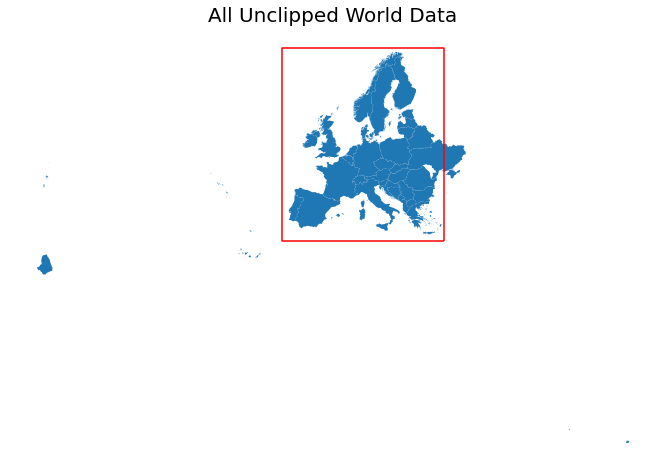

In [88]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
gdf_countries_BS_BS.plot(ax=ax1)
poly_gdf.boundary.plot(ax=ax1, color="red")
ax1.set_title("All Unclipped World Data", fontsize=20)
ax1.set_axis_off()
plt.show()

In [89]:
#clip the map to the selected frame in the polygon and drop unnecessary countries
gdf_countries_BS_BS_clipped = gpd.clip(gdf_countries_BS_BS, poly_gdf)
#gdf_countries_BS_BS_clipped = gdf_countries_BS_BS_clipped.drop(['DZ','GG','FO','GL','IM','IS','JE','MT','MA','SM','TN', 'TR', 'RU'])

In [90]:
MCDA_Results = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Criteria_PT_Scenario.xlsx', sheet_name = 'Results')
MCDA_Results = MCDA_Results.set_index('country')
gdf_countries_BS_BS_clipped = gdf_countries_BS_BS_clipped.join(MCDA_Results)
gdf_countries_BS_BS_clipped

id                                          CNTR_NAME  \
country                                                          
BE       BE                            Belgien-Belgique-België   
BG       BG                                           България   
CZ       CZ                                    Česká Republika   
DK       DK                                            Danmark   
DE       DE                                        Deutschland   
...      ..                                                ...   
AL       AL                                          Shqipëria   
RS       RS                                             Србија   
BA       BA  Bosna I Hercegovina-Bosna I Hercegovina-Босна ...   
BY       BY                                           Беларусь   
UA       UA                                            Україна   

                      NAME_ENGL ISO3_CODE FID  \
country                                         
BE                      Belgium       BEL  BE   
BG                     Bulgaria       BGR  BG   
CZ                      Czechia       CZE  CZ   
DK                      Denmark       DNK  DK   
DE                      Germany       DEU  DE   
...                         ...       ...  ..   
AL                      Albania       ALB  AL   
RS                       Serbia       SRB  RS   
BA       Bosnia and Herzegovina       BIH  BA   
BY                      Belarus       BLR  BY   
UA                      Ukraine       UKR  UA   

                                                  geometry       2050_BS  \
country                                                                    
BE       MULTIPOLYGON (((4040360.185 3079039.389, 40416...   7315.669045   
BG       POLYGON ((5330611.947 2430822.479, 5332044.063...  25471.659167   
CZ       POLYGON ((4660255.779 3095529.143, 4660822.043...  19529.396745   
DK       MULTIPOLYGON (((4650502.736 3591342.844, 46503...   3838.388365   
DE       MULTIPOLYGON (((4355225.365 2715902.993, 43541...  65355.919147   
...                                                    ...           ...   
AL       MULTIPOLYGON (((5148385.473 2216598.889, 51491...           NaN   
RS       MULTIPOLYGON (((5112369.786 2611777.777, 51124...           NaN   
BA       POLYGON ((5066457.268 2314658.245, 5065610.272...           NaN   
BY       POLYGON ((5260075.682 3243410.171, 5260432.337...           NaN   
UA       MULTIPOLYGON (((6000000.000 2819636.960, 59986...           NaN   

              2050_BC Reference Scenario High Biodiesel Share High CEV Share  
country                                                                       
BE        2166.298812            Bio_Syn              Bio_Syn        Bio_Syn  
BG        8465.032251            BEV_CEV              BEV_CEV        BEV_CEV  
CZ        5684.660620            Bio_Syn              Bio_Syn        Bio_Syn  
DK        1147.450723            BEV_CEV              Bio_Syn        BEV_CEV  
DE       19523.014488            Bio_Syn              Bio_Syn        BEV_CEV  
...               ...                ...                  ...            ...  
AL                NaN                NaN                  NaN            NaN  
RS                NaN                NaN                  NaN            NaN  
BA                NaN                NaN                  NaN            NaN  
BY                NaN                NaN                  NaN            NaN  
UA                NaN                NaN                  NaN            NaN  

[35 rows x 11 columns]

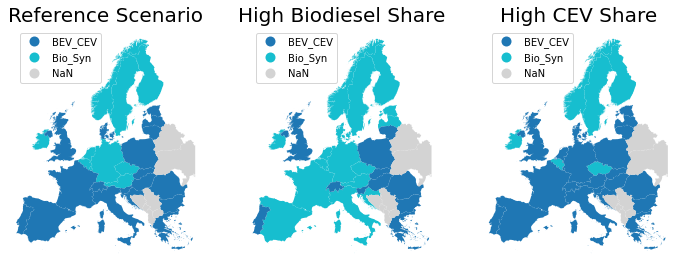

In [91]:
# Plot the clipped data
# The plot below shows the results of the clip function applied to the world
# sphinx_gallery_thumbnail_number = 2
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12, 12))
gdf_countries_BS_BS_clipped.plot(column = 'Reference Scenario', ax=ax1, missing_kwds={"color": "lightgrey",}, 
                                 legend = True, legend_kwds={'bbox_to_anchor': (0.5, 1)})
gdf_countries_BS_BS_clipped.plot(column = 'High Biodiesel Share', ax=ax2, missing_kwds={"color": "lightgrey",},
                                 legend = True, legend_kwds={'bbox_to_anchor': (0.5, 1)})
gdf_countries_BS_BS_clipped.plot(column = 'High CEV Share', ax=ax3, missing_kwds={"color": "lightgrey",},
                                 legend = True, legend_kwds={'bbox_to_anchor': (0.5, 1)})
ax1.set_title("Reference Scenario", fontsize=20)
ax2.set_title("High Biodiesel Share", fontsize=20)
ax3.set_title("High CEV Share", fontsize=20)
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
#ax1.legend()
#plt.legend(handles = ['scenario_ref', 'scenario_bio'], labels = ['scenario_ref', 'scenario_bio'])
plt.show()
fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/MCDA_Results.png")

# Transport Demand Plot

In [92]:
Mio_Vkm_Country = Mio_Vkm.groupby('country').sum()

In [93]:
Mio_Vkm_Country = Mio_Vkm_Country.reset_index()

In [94]:
Mio_Vkm_Country_sort = Mio_Vkm_Country.sort_values(by = [2050])

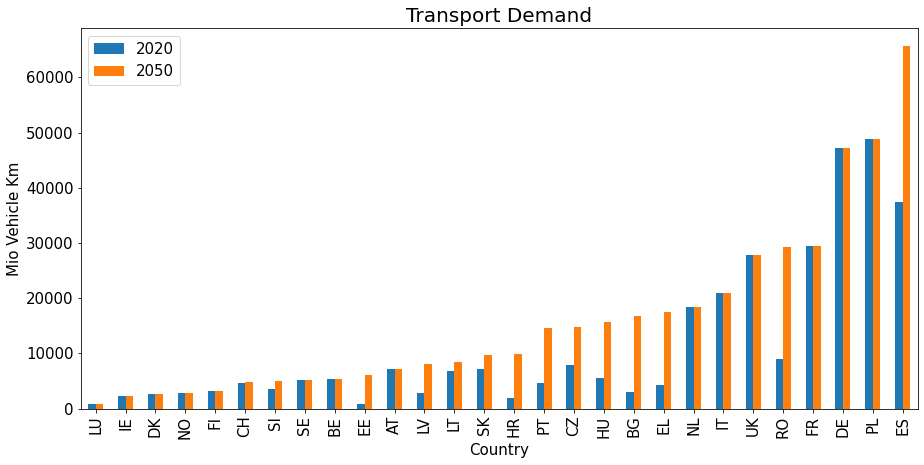

In [95]:
fig, ax = plt.subplots(1, 1, figsize = (15,7))

ax.margins(x=0)

Mio_Vkm_Country_sort.plot.bar(ax=ax,
                         x = 'country',
                         y = [2020, 2050],
                        fontsize = 15)
plt.xlabel('Country', fontsize=15)
plt.ylabel('Mio Vehicle Km', fontsize = 15)
plt.title('Transport Demand', fontsize = 20)
plt.legend(prop = {'size':15})

fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/Transport_Demand.png")

In [96]:
pd.set_option('display.max_rows', 28)  # or 1000
Mio_Vkm_Country_sort_2050 = Mio_Vkm_Country_sort.set_index('country')
Mio_Vkm_Country_sort_2050[2050]

country
LU      914.000000
IE     2266.000000
DK     2700.000000
NO     2928.000000
FI     3138.000000
CH     4850.371429
SI     5089.220996
SE     5274.000000
BE     5288.000000
EE     6081.923274
AT     7178.000000
LV     8115.837893
LT     8379.549588
SK     9800.609911
HR     9870.989932
PT    14653.751509
CZ    14801.792276
HU    15733.364028
BG    16713.620584
EL    17434.861644
NL    18482.000000
IT    20874.000000
UK    27836.000000
RO    29305.175146
FR    29464.000000
DE    47208.000000
PL    48798.000000
ES    65618.166026
Name: 2050, dtype: float64

In [97]:
#Mio_Vkm_Country = Mio_Vkm_Country[2050]
#Mio_Vkm_Country = Mio_Vkm_Country.to_frame()

In [99]:
# devide transport demand in Vkm of each region by the road km of each region
#Mio_Vkm_Country = Mio_Vkm_Country.set_index('country')
#Mio_Vkm_Country.set_index('country')
#Mio_Vkm_Country.rename(index = {'country': 'id'})

#road_km_country
#T_d_Region = T_d_Region.droplevel(level=1)
Vkm_Country = Mio_Vkm_Country.multiply(1000000)
Mio_Vkm_Country = Mio_Vkm_Country.set_index('country')
T_d_Country_divkm = Mio_Vkm_Country[[2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050]].div(road_km_country.road_km, axis = 0)
gdf_t_d_Country_divkm = gdf_countries_BS_BS_clipped.join(T_d_Country_divkm)

In [100]:
TOP10_Country_t_d = Mio_Vkm_Country.nlargest(10, 2050, keep='first')

In [101]:
TOP10_Country_t_d_divkm = gdf_t_d_Country_divkm.nlargest(10, 2050, keep='first')

In [102]:
T_d_Country_divkm_sort = T_d_Country_divkm.sort_values(by = [2050])

In [103]:
T_d_Country_divkm_sort = T_d_Country_divkm_sort.drop(['AL', 'BA', 'BY', 'ME', 'MK', 'RS', 'UA'])

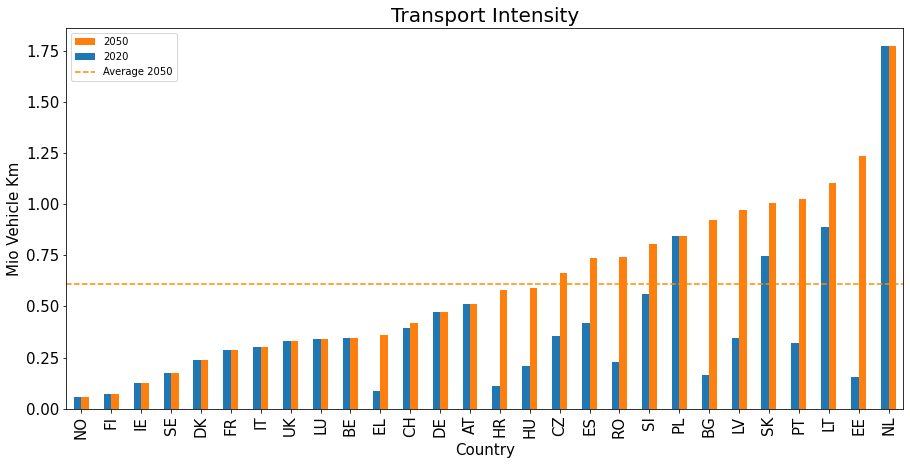

In [105]:
fig, ax = plt.subplots(1, 1, figsize = (15,7))

ax.margins(x=0)

T_d_Country_divkm_sort.plot.bar(ax=ax,
                         y = [2020, 2050],
                        fontsize = 15)
plt.xlabel('Country', fontsize=15)
plt.ylabel('Mio Vehicle Km', fontsize = 15)
plt.title('Transport Intensity', fontsize = 20)
#plt.legend(prop = {'size':15})

# use axhline
#mean_2020 = T_d_Country_divkm_sort[2020].mean()
#ax.axhline(mean_2020)
mean_2050 = T_d_Country_divkm_sort[2050].mean()
ax.axhline(mean_2050, color = 'darkorange', linestyle = '--', label = 'Average 2050')
plt.legend(prop = {'size':15})
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left')

fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/Transport_Demand_divkm.png")

In [106]:
T_d_Country_divkm = T_d_Country_divkm.drop(['AL', 'BA', 'BY', 'ME', 'MK', 'RS', 'UA'])
T_d_Country_divkm_sort_2050 = T_d_Country_divkm[2050]
T_d_Country_divkm_sort_2050.to_frame()

2050
AT  0.511755
BE  0.347654
BG  0.920009
CH  0.418709
CZ  0.665437
DE  0.471918
DK  0.238887
EE  1.232987
EL  0.361094
ES  0.733905
FI  0.072938
FR  0.285220
HR  0.582109
HU  0.589495
IE  0.124187
IT  0.299754
LT  1.103198
LU  0.338213
LV  0.971809
NL  1.770962
NO  0.054685
PL  0.844780
PT  1.022352
RO  0.741750
SE  0.172745
SI  0.803453
SK  1.007470
UK  0.331240

In [107]:
Mio_Vkm_Country.T.plot.bar
  #xlabel = 'Year',
                          #ylabel = 'Mio Vehicle Km',
                          #logy = True

<bound method PlotAccessor.bar of <pandas.plotting._core.PlotAccessor object at 0x0000026A8A7EA3D0>>

Sensitivity Analysis on Country and Regional Level

In [108]:
# Sensitivity Analysis on Transport Demand
Mio_Vkm_20P = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'vkm_+20%')
Mio_Vkm_20P = Mio_Vkm_20P.set_index(['country','distance_class'])
Mio_Vkm_50P = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'vkm_+50%')
Mio_Vkm_50P = Mio_Vkm_50P.set_index(['country','distance_class'])
Mio_Vkm_m20P = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'vkm_-20%')
Mio_Vkm_m20P = Mio_Vkm_m20P.set_index(['country','distance_class'])
Mio_Vkm_m50P = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'vkm_-50%')
Mio_Vkm_m50P = Mio_Vkm_m50P.set_index(['country','distance_class'])
Mio_Vkm_ED = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'vkm_equal')
Mio_Vkm_ED = Mio_Vkm_ED.set_index(['country','distance_class'])

In [109]:
Mio_Vkm_20P = Mio_Vkm_20P.groupby('country').sum()
Mio_Vkm_20P = Mio_Vkm_20P.reset_index()
Mio_Vkm_20P = Mio_Vkm_20P.sort_values(by = [2050])
Mio_Vkm_50P = Mio_Vkm_50P.groupby('country').sum()
Mio_Vkm_50P = Mio_Vkm_50P.reset_index()
Mio_Vkm_50P = Mio_Vkm_50P.sort_values(by = [2050])
Mio_Vkm_m20P = Mio_Vkm_m20P.groupby('country').sum()
Mio_Vkm_m20P = Mio_Vkm_m20P.reset_index()
Mio_Vkm_m20P = Mio_Vkm_m20P.sort_values(by = [2050])
Mio_Vkm_m50P = Mio_Vkm_m50P.groupby('country').sum()
Mio_Vkm_m50P = Mio_Vkm_m50P.reset_index()
Mio_Vkm_m50P = Mio_Vkm_m50P.sort_values(by = [2050])
Mio_Vkm_ED = Mio_Vkm_ED.groupby('country').sum()
Mio_Vkm_ED = Mio_Vkm_ED.reset_index()
Mio_Vkm_ED = Mio_Vkm_ED.sort_values(by = [2050])

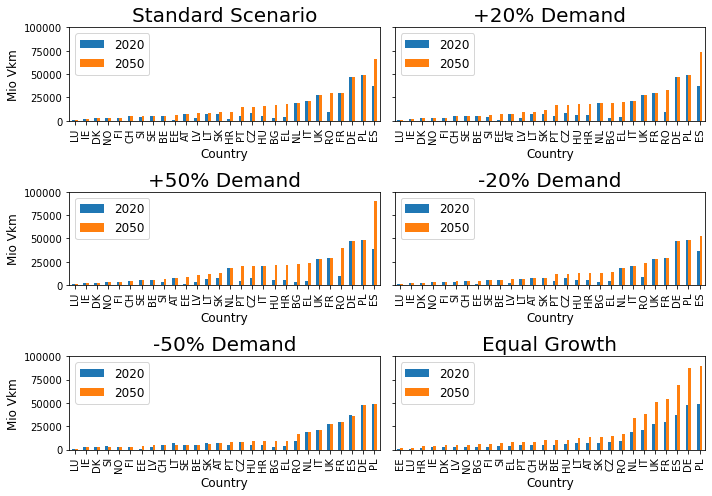

In [110]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize = (10,7))


Mio_Vkm_Country_sort.plot.bar(ax=ax1,
                         x = 'country',
                         y = [2020, 2050],
                        fontsize = 10)
Mio_Vkm_20P.plot.bar(ax=ax2,
                         x = 'country',
                         y = [2020, 2050],
                        fontsize = 10)
Mio_Vkm_50P.plot.bar(ax=ax3,
                         x = 'country',
                         y = [2020, 2050],
                        fontsize = 10)
Mio_Vkm_m20P.plot.bar(ax=ax4,
                         x = 'country',
                         y = [2020, 2050],
                        fontsize = 10)
Mio_Vkm_m50P.plot.bar(ax=ax5,
                         x = 'country',
                         y = [2020, 2050],
                        fontsize = 10)
Mio_Vkm_ED.plot.bar(ax=ax6,
                         x = 'country',
                         y = [2020, 2050],
                        fontsize = 10)
#ax1.margins(x=0)
#ax2.margins(x=0)
#ax3.margins(x=0)
#ax4.margins(x=0)
#ax5.margins(x=0)
#ax6.margins(x=0)
ax1.set_ylim(0,100000)
ax2.set_ylim(0,100000)
ax3.set_ylim(0,100000)
ax4.set_ylim(0,100000)
ax5.set_ylim(0,100000)
ax6.set_ylim(0,100000)
ax1.set_title("Standard Scenario", fontsize=20)
ax2.set_title("+20% Demand", fontsize=20)
ax3.set_title("+50% Demand", fontsize=20)
ax4.set_title("-20% Demand", fontsize=20)
ax5.set_title("-50% Demand", fontsize=20)
ax6.set_title("Equal Growth", fontsize=20)
ax1.set_ylabel("Mio Vkm", fontsize=12)
#ax2.set_ylabel("Mio Vkm", fontsize=12)
ax3.set_ylabel("Mio Vkm", fontsize=12)
#ax4.set_ylabel("Mio Vkm", fontsize=12)
ax5.set_ylabel("Mio Vkm", fontsize=12)
#ax6.set_ylabel("Mio Vkm", fontsize=12)
ax1.set_xlabel('Country', fontsize=12)
ax2.set_xlabel('Country', fontsize=12)
ax3.set_xlabel('Country', fontsize=12)
ax4.set_xlabel('Country', fontsize=12)
ax5.set_xlabel('Country', fontsize=12)
ax6.set_xlabel('Country', fontsize=12)
ax1.legend(loc=2, prop={'size': 12})
ax2.legend(loc=2, prop={'size': 12})
ax3.legend(loc=2, prop={'size': 12})
ax4.legend(loc=2, prop={'size': 12})
ax5.legend(loc=2, prop={'size': 12})
ax6.legend(loc=2, prop={'size': 12})
ax2.set_yticklabels([])
ax4.set_yticklabels([])
ax6.set_yticklabels([])

plt.tight_layout()



#plt.ylabel('Mio Vehicle Km', fontsize = 15)
#plt.title('Transport Demand +20%', fontsize = 20)
#plt.legend(prop = {'size':15})

fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/sensitivity_analysis_TD_Country.png")

In [111]:
Mio_Vkm_ED = Mio_Vkm_ED.set_index(['country'])
Mio_Vkm_m50P = Mio_Vkm_m50P.set_index(['country'])

In [112]:
Vkm_ED = Mio_Vkm_ED.multiply(1000000)
Vkm_m50P = Mio_Vkm_m50P.multiply(1000000)

In [113]:
#calculate vkm per country
Vkm_country = Vkm.groupby('country').sum()

In [114]:
#calculate transport demand (Vkm) per region
T_d_Region = Vkm_country.multiply(t_s_NUTS3)
T_d_Region_ED = Vkm_ED.multiply(t_s_NUTS3)
T_d_Region_m50P = Vkm_m50P.multiply(t_s_NUTS3)

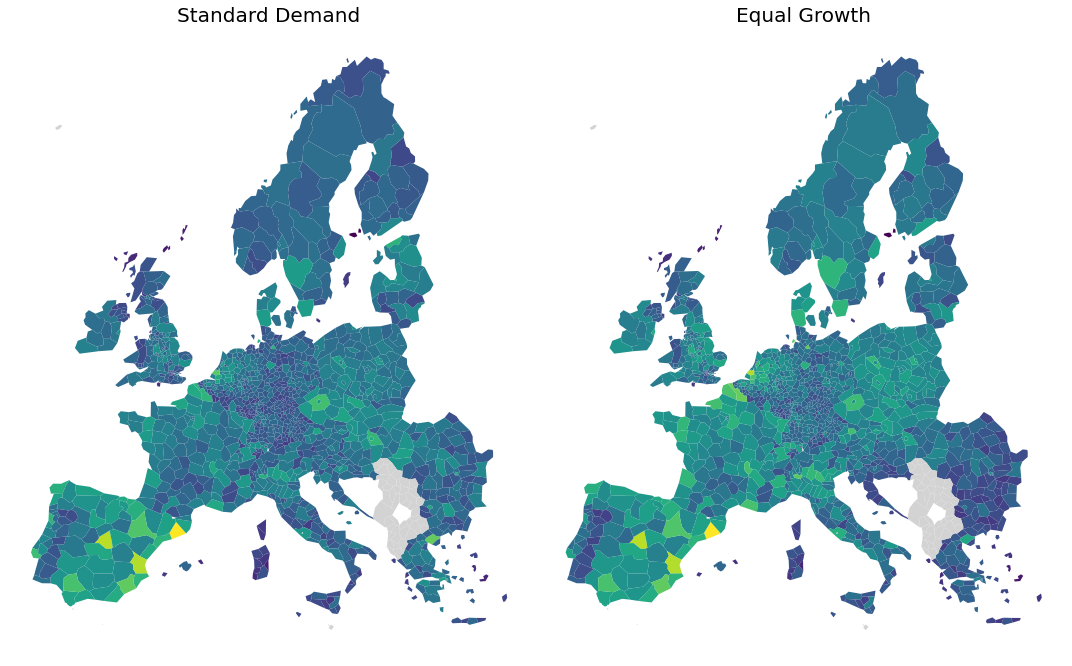

In [115]:
# Plot transport demand per region
gdf_T_d_Region = gdf_dw.join(T_d_Region)
gdf_T_d_Region = gdf_T_d_Region.replace(0, np.nan)
gdf_T_d_Region_ED = gdf_dw.join(T_d_Region_ED)
gdf_T_d_Region_ED = gdf_T_d_Region_ED.replace(0, np.nan)
gdf_T_d_Region_m50P = gdf_dw.join(T_d_Region_m50P)
gdf_T_d_Region_m50P = gdf_T_d_Region_m50P.replace(0, np.nan)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,15))
#divider2 = make_axes_locatable(ax2)
#cax2 = divider2.append_axes("right", size="5%", pad=0.5)
#divider1 = make_axes_locatable(ax1)
#cax1 = divider1.append_axes("right", size="5%", pad=0.5)
#divider3 = make_axes_locatable(ax3)
#cax3 = divider3.append_axes("right", size="5%", pad=0.5)
ax1.axis('off')
ax1.set_title("Standard Demand", fontsize=20)
ax2.axis('off')
ax2.set_title("Equal Growth", fontsize=20)
#ax3.axis('off')
#ax3.set_title("-50% Demand", fontsize=20)


gdf_T_d_Region.plot(column = 2050, 
                         ax=ax1,
                        legend=False,
                        #cax = cax2,
                       #legend_kwds = {'label': 'Transport Demand (Vkm)'},
                        cmap = 'viridis',
                        norm=mcolors.PowerNorm(0.3),
                        missing_kwds= dict(color = "lightgrey"))
gdf_T_d_Region_ED.plot(column = 2050, 
                         ax=ax2,
                        legend=True,
                        cax = cax1,
                        #legend_kwds = {'label': 'Transport Demand (Vkm)'},
                        cmap = 'viridis',
                        norm=mcolors.PowerNorm(0.3),
                        missing_kwds= dict(color = "lightgrey"))
#gdf_T_d_Region_ED.plot(column = 2050, 
 #                        ax=ax3,
  #                      legend=True,
   #                     cax = cax3,
    #                    legend_kwds = {'label': 'Transport Demand (Vkm)'},
     #                   cmap = 'viridis',
      #                  norm=mcolors.PowerNorm(0.3),
       #                 missing_kwds= dict(color = "lightgrey"))
plt.tight_layout()

fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/Sensitivity_TransportDemand.png")

# Transport Demand Share per Region

In [116]:
#calculate vkm per country
Vkm_country = Vkm.groupby('country').sum()

In [117]:
#calculate transport demand (Vkm) per region
T_d_Region = Vkm_country.multiply(t_s_NUTS3)

In [118]:
# devide transport demand in Vkm of each region by the road km of each region
T_d_Region = T_d_Region.droplevel(level=1)
T_d_Region_divkm = T_d_Region[[2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050]].div(road_km_select.road_km, axis = 0)
gdf_t_d_NUTS3_divkm = gdf_dw.join(T_d_Region_divkm)

In [119]:
TOP10_t_d = T_d_Region.nlargest(10, 2050, keep='first')

In [120]:
TOP10_t_d_divkm = T_d_Region_divkm.nlargest(10, 2050, keep='first')

In [121]:
TOP10_t_d_divkm

2020          2021          2022          2023          2024  \
id                                                                            
LV006  6.698559e+06  7.102694e+06  7.506828e+06  7.910963e+06  8.315098e+06   
DE502  1.425628e+07  1.425628e+07  1.425628e+07  1.425628e+07  1.425628e+07   
EL303  2.664649e+06  2.936954e+06  3.209260e+06  3.481565e+06  3.753871e+06   
DEA14  9.465568e+06  9.465568e+06  9.465568e+06  9.465568e+06  9.465568e+06   
DE122  9.406449e+06  9.406449e+06  9.406449e+06  9.406449e+06  9.406449e+06   
DEB34  9.153689e+06  9.153689e+06  9.153689e+06  9.153689e+06  9.153689e+06   
FR101  8.911652e+06  8.911652e+06  8.911652e+06  8.911652e+06  8.911652e+06   
DEA12  7.342297e+06  7.342297e+06  7.342297e+06  7.342297e+06  7.342297e+06   
NL333  7.162608e+06  7.162608e+06  7.162608e+06  7.162608e+06  7.162608e+06   
RO321  2.068338e+06  2.221952e+06  2.375565e+06  2.529178e+06  2.682792e+06   

               2025          2026          2027          2028          2029  \
id                                                                            
LV006  8.719232e+06  9.123367e+06  9.527501e+06  9.931636e+06  1.033577e+07   
DE502  1.425628e+07  1.425628e+07  1.425628e+07  1.425628e+07  1.425628e+07   
EL303  4.026176e+06  4.298482e+06  4.570787e+06  4.843092e+06  5.115398e+06   
DEA14  9.465568e+06  9.465568e+06  9.465568e+06  9.465568e+06  9.465568e+06   
DE122  9.406449e+06  9.406449e+06  9.406449e+06  9.406449e+06  9.406449e+06   
DEB34  9.153689e+06  9.153689e+06  9.153689e+06  9.153689e+06  9.153689e+06   
FR101  8.911652e+06  8.911652e+06  8.911652e+06  8.911652e+06  8.911652e+06   
DEA12  7.342297e+06  7.342297e+06  7.342297e+06  7.342297e+06  7.342297e+06   
NL333  7.162608e+06  7.162608e+06  7.162608e+06  7.162608e+06  7.162608e+06   
RO321  2.836405e+06  2.990019e+06  3.143632e+06  3.297246e+06  3.450859e+06   

       ...          2041          2042          2043          2044  \
id     ...                                                           
LV006  ...  1.518539e+07  1.558952e+07  1.599366e+07  1.639779e+07   
DE502  ...  1.425628e+07  1.425628e+07  1.425628e+07  1.425628e+07   
EL303  ...  8.383063e+06  8.655369e+06  8.927674e+06  9.199980e+06   
DEA14  ...  9.465568e+06  9.465568e+06  9.465568e+06  9.465568e+06   
DE122  ...  9.406449e+06  9.406449e+06  9.406449e+06  9.406449e+06   
DEB34  ...  9.153689e+06  9.153689e+06  9.153689e+06  9.153689e+06   
FR101  ...  8.911652e+06  8.911652e+06  8.911652e+06  8.911652e+06   
DEA12  ...  7.342297e+06  7.342297e+06  7.342297e+06  7.342297e+06   
NL333  ...  7.162608e+06  7.162608e+06  7.162608e+06  7.162608e+06   
RO321  ...  5.294221e+06  5.447834e+06  5.601448e+06  5.755061e+06   

               2045          2046          2047          2048          2049  \
id                                                                            
LV006  1.680192e+07  1.720606e+07  1.761019e+07  1.801433e+07  1.841846e+07   
DE502  1.425628e+07  1.425628e+07  1.425628e+07  1.425628e+07  1.425628e+07   
EL303  9.472285e+06  9.744590e+06  1.001690e+07  1.028920e+07  1.056151e+07   
DEA14  9.465568e+06  9.465568e+06  9.465568e+06  9.465568e+06  9.465568e+06   
DE122  9.406449e+06  9.406449e+06  9.406449e+06  9.406449e+06  9.406449e+06   
DEB34  9.153689e+06  9.153689e+06  9.153689e+06  9.153689e+06  9.153689e+06   
FR101  8.911652e+06  8.911652e+06  8.911652e+06  8.911652e+06  8.911652e+06   
DEA12  7.342297e+06  7.342297e+06  7.342297e+06  7.342297e+06  7.342297e+06   
NL333  7.162608e+06  7.162608e+06  7.162608e+06  7.162608e+06  7.162608e+06   
RO321  5.908675e+06  6.062288e+06  6.215902e+06  6.369515e+06  6.523128e+06   

               2050  
id                   
LV006  1.882260e+07  
DE502  1.425628e+07  
EL303  1.083381e+07  
DEA14  9.465568e+06  
DE122  9.406449e+06  
DEB34  9.153689e+06  
FR101  8.911652e+06  
DEA12  7.342297e+06  
NL333  7.162608e+06  
RO321  6.676742e+06  

[10 rows x 31 columns]

In [122]:
TOP10_Vkm_country = Vkm_country.nlargest(10, 2050, keep='first')

In [123]:
#identify region with highest value
column = gdf_t_d_NUTS3_divkm[2050]
max_value = column.max()
max_index = column.idxmax()
max_index

'LV006'

In [124]:
#Set specific regions to Nan values
gdf_t_d_NUTS3_divkm_2050_q99 = gdf_t_d_NUTS3_divkm[2050].quantile(q = 0.99)
top_1p_regions_t_d = gdf_t_d_NUTS3_divkm[gdf_t_d_NUTS3_divkm[2050] > 5566445.463324031]

#gdf_t_d_NUTS3_divkm.loc['LV006', 2050]= np.nan
#gdf_t_d_NUTS3_divkm.loc['DE502', 2050]= np.nan
#gdf_t_d_NUTS3_divkm.loc['EL303', 2050]= np.nan

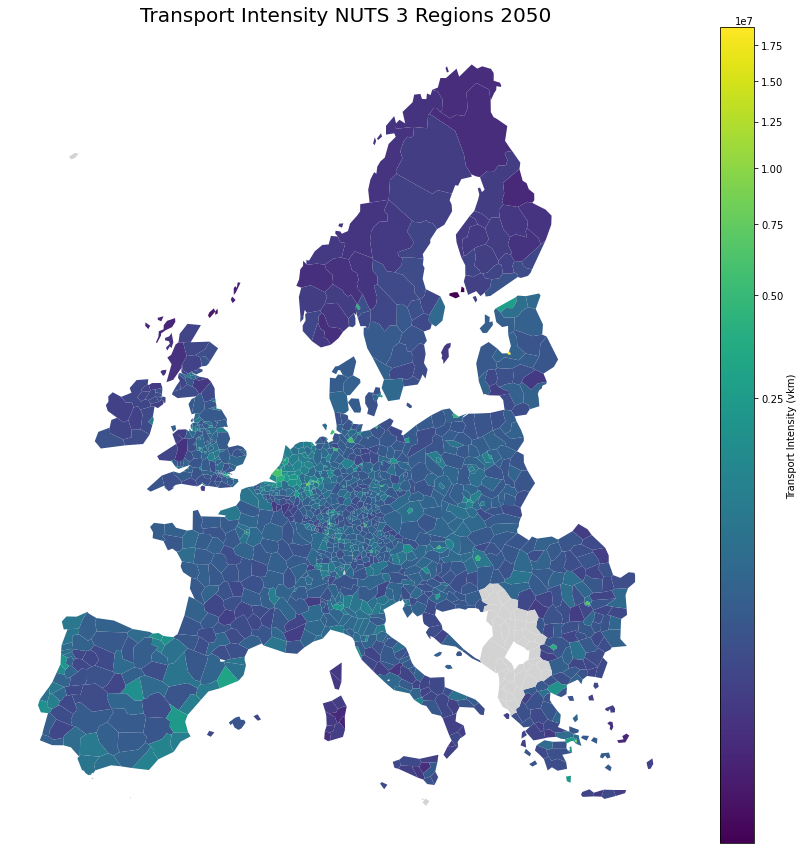

In [177]:
# Plot transport demand devided by road km per region
gdf_t_d_NUTS3_divkm = gdf_t_d_NUTS3_divkm.replace(0, np.nan)

fig, (ax2) = plt.subplots(1, 1, figsize = (15,15))
#divider1 = make_axes_locatable(ax1)
#cax1 = divider1.append_axes("right", size="5%", pad=0.5)
#ax1.axis('off')
#ax1.set_title("Transport Demand per Region 2020", fontsize=20)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.5)
ax2.axis('off')
ax2.set_title("Transport Intensity NUTS 3 Regions 2050", fontsize=20)

#gdf_t_d_NUTS3_divkm.plot(column = 2020, 
                              #    ax=ax1,
                               #  legend=True,
                                #  cax = cax1,
                                 # legend_kwds = {'label': 'Energy Consumption 2020 (Vkm)'},
                                 #cmap = 'viridis',
                                 #norm=mcolors.PowerNorm(0.3),
                                 #missing_kwds= dict(color = "lightgrey"))
gdf_t_d_NUTS3_divkm.plot(column = 2050, 
                                  ax=ax2,
                                 legend=True,
                                  cax = cax2,
                                  legend_kwds = {'label': 'Transport Intensity (vkm)'},
                                 cmap = 'viridis',
                                 norm=mcolors.PowerNorm(0.3),
                                 missing_kwds= dict(color = "lightgrey"))
fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/TransportIntensityPerRegion.png")

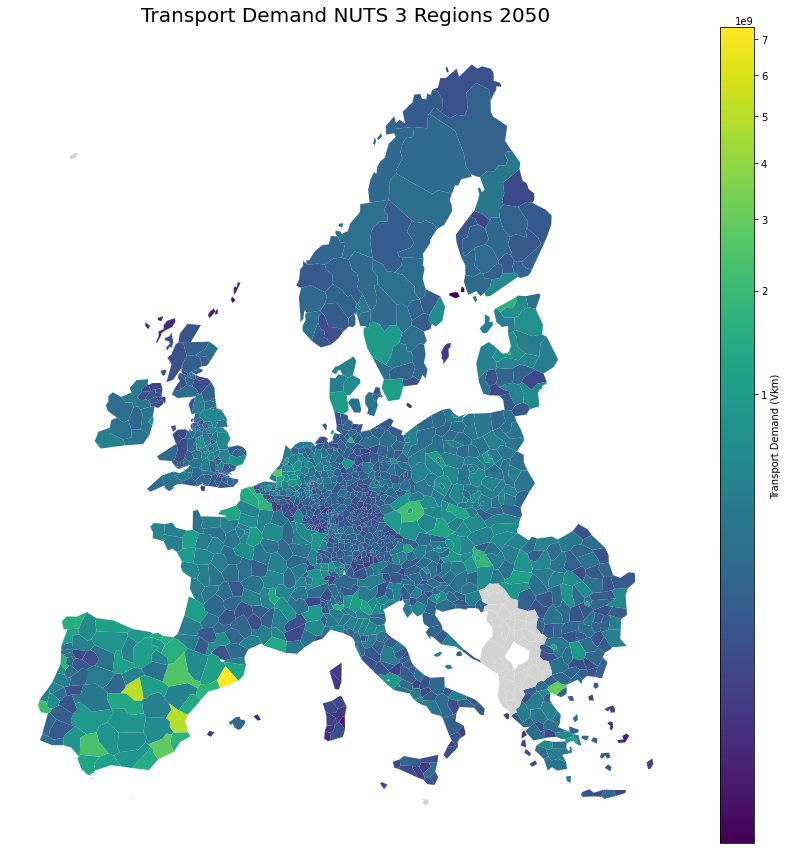

In [126]:
# Plot transport demand per region
gdf_T_d_Region = gdf_dw.join(T_d_Region)
gdf_T_d_Region = gdf_T_d_Region.replace(0, np.nan)

fig, ax2 = plt.subplots(1, 1, figsize = (15,15))
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.5)
ax2.axis('off')
ax2.set_title("Transport Demand NUTS 3 Regions 2050", fontsize=20)

gdf_T_d_Region.plot(column = 2050, 
                         ax=ax2,
                        legend=True,
                        cax = cax2,
                        legend_kwds = {'label': 'Transport Demand (Vkm)'},
                        cmap = 'viridis',
                        norm=mcolors.PowerNorm(0.3),
                        missing_kwds= dict(color = "lightgrey"))

fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/TransportDemand.png")

Histogramms

In [127]:
T_d_Region_2050 = T_d_Region[2050]
T_d_Region_2050 = T_d_Region_2050.to_frame()
T_d_Region_2050 = T_d_Region_2050.rename(columns = {2050: '2050 Demand'})


<AxesSubplot:ylabel='Frequency'>

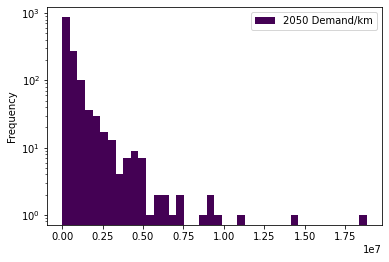

In [128]:
T_d_Region_divkm_2050 = T_d_Region_divkm[2050]
T_d_Region_divkm_2050 = T_d_Region_divkm_2050.to_frame()
T_d_Region_divkm_2050 = T_d_Region_divkm_2050.rename(columns = {2050: '2050 Demand/km'})
T_d_Region_divkm_2050.plot.hist(logy=True, bins=40, cmap = 'viridis')

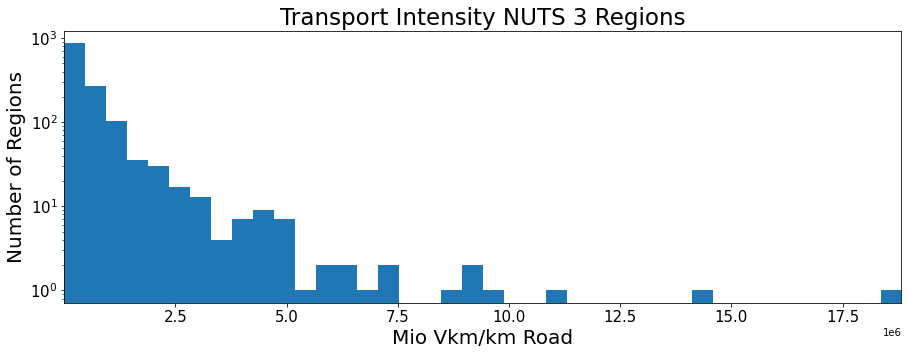

In [129]:
fig, ax1 = plt.subplots(1, figsize = (15,5))

ax1.set_title("Transport Intensity NUTS 3 Regions", fontsize=23)
T_d_Region_divkm_2050.plot.hist(logy=True, bins=40, ax = ax1, legend=False)
ax1.set_ylabel('Number of Regions', fontsize = 20)
ax1.set_xlabel('Mio Vkm/km Road', fontsize = 20)
ax1.margins(x=0)
ax1.ticklabel_format(axis = 'x', scilimits = (6,6))
ax1.tick_params(labelsize = 15)


fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/Regions_divkm_Hist.png")

In [130]:
T_d_Region_divkm_2050.dropna()

2050 Demand/km
id                   
AT111   212271.268900
AT112   363755.714458
AT113   222619.497446
AT121   490113.658541
AT122   314759.569372
...               ...
UKN12    57768.213352
UKN13   146290.275028
UKN14   128809.259215
UKN15   172143.504581
UKN16   105375.262950

[1375 rows x 1 columns]

In [131]:
regions_largerthan_177 = T_d_Region_divkm_2050[T_d_Region_divkm_2050['2050 Demand/km'] > 1770000]
regions_largerthan_177

2050 Demand/km
id                   
AT130    4.718040e+06
AT221    1.853132e+06
AT312    1.774038e+06
BE211    2.268803e+06
BE324    2.452348e+06
...               ...
UKH32    4.243200e+06
UKI31    2.863478e+06
UKJ32    3.748061e+06
UKJ43    2.206704e+06
UKK11    6.408532e+06

[109 rows x 1 columns]

In [132]:
T_d_Region_divkm_2050_test = T_d_Region_divkm_2050.multiply(10)
T_d_Region_divkm_2050_test

2050 Demand/km
id                   
AL011             NaN
AL012             NaN
AL013             NaN
AL014             NaN
AL015             NaN
...               ...
UKN12    5.776821e+05
UKN13    1.462903e+06
UKN14    1.288093e+06
UKN15    1.721435e+06
UKN16    1.053753e+06

[1522 rows x 1 columns]

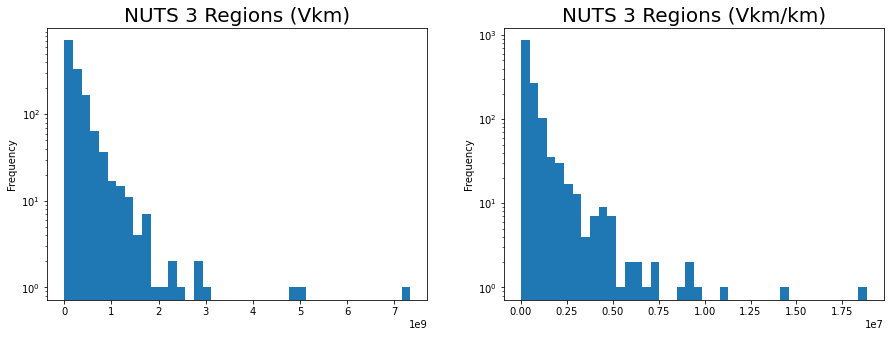

In [133]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))

ax1.set_title("NUTS 3 Regions (Vkm)", fontsize=20)
ax2.set_title("NUTS 3 Regions (Vkm/km)", fontsize=20)

T_d_Region_2050.plot.hist(logy=True, bins=40, ax = ax1, legend=False)
T_d_Region_divkm_2050.plot.hist(logy=True, bins=40, ax = ax2, legend=False)

fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/Regions_Hist.png")

In [134]:
#T_d_Region_2050 = T_d_Region_2050.reset_index()
#T_d_Region_divkm_2050 = T_d_Region_divkm_2050.reset_index()
#T_d_Region_hist = pd.concat((T_d_Region_divkm_2050, T_d_Region_2050))
#T_d_Region_hist

# Plot for Energy demand of Top Regions vs Bottom regions

In [135]:
100/1382*208

15.050651230101302

In [136]:
T_d_Region_2050_q99 = T_d_Region[2050].quantile(q = 0.99)
T_d_Region_2050_q95 = T_d_Region[2050].quantile(q = 0.95)
T_d_Region_2050_q90 = T_d_Region[2050].quantile(q = 0.90)
T_d_Region_2050_q85 = T_d_Region[2050].quantile(q = 0.85)
T_d_Region_2050_q70 = T_d_Region[2050].quantile(q = 0.70)
T_d_Region_2050_q55 = T_d_Region[2050].quantile(q = 0.55)
T_d_Region_2050_q40 = T_d_Region[2050].quantile(q = 0.40)

top_1p_regions_t_d = T_d_Region[T_d_Region[2050] > T_d_Region_2050_q99]
bot_99p_regions_t_d = T_d_Region[T_d_Region[2050] <= T_d_Region_2050_q99]
top_5p_regions_t_d = T_d_Region[T_d_Region[2050] > T_d_Region_2050_q95]
bot_95p_regions_t_d = T_d_Region[T_d_Region[2050] <= T_d_Region_2050_q95]
top_10p_regions_t_d = T_d_Region[T_d_Region[2050] > T_d_Region_2050_q90]
bot_90p_regions_t_d = T_d_Region[T_d_Region[2050] <= T_d_Region_2050_q90]
top_15p_regions_t_d = T_d_Region[T_d_Region[2050] > T_d_Region_2050_q85]
bot_85p_regions_t_d = T_d_Region[T_d_Region[2050] <= T_d_Region_2050_q85]
top_30p_regions_t_d = T_d_Region[T_d_Region[2050] > T_d_Region_2050_q70]
bot_70p_regions_t_d = T_d_Region[T_d_Region[2050] <= T_d_Region_2050_q70]
top_45p_regions_t_d = T_d_Region[T_d_Region[2050] > T_d_Region_2050_q55]
bot_55p_regions_t_d = T_d_Region[T_d_Region[2050] <= T_d_Region_2050_q55]
top_60p_regions_t_d = T_d_Region[T_d_Region[2050] > T_d_Region_2050_q40]
bot_40p_regions_t_d = T_d_Region[T_d_Region[2050] <= T_d_Region_2050_q40]

top_1p_regions_t_d = top_1p_regions_t_d.loc[:,2050]
bot_99p_regions_t_d = bot_99p_regions_t_d.loc[:,2050]
top_5p_regions_t_d = top_5p_regions_t_d.loc[:,2050]
bot_95p_regions_t_d = bot_95p_regions_t_d.loc[:,2050]
top_10p_regions_t_d = top_10p_regions_t_d.loc[:,2050]
bot_90p_regions_t_d = bot_90p_regions_t_d.loc[:,2050]
top_15p_regions_t_d = top_15p_regions_t_d.loc[:,2050]
bot_85p_regions_t_d = bot_85p_regions_t_d.loc[:,2050]
top_30p_regions_t_d = top_30p_regions_t_d.loc[:,2050]
bot_70p_regions_t_d = bot_70p_regions_t_d.loc[:,2050]
top_45p_regions_t_d = top_45p_regions_t_d.loc[:,2050]
bot_55p_regions_t_d = bot_55p_regions_t_d.loc[:,2050]
top_60p_regions_t_d = top_60p_regions_t_d.loc[:,2050]
bot_40p_regions_t_d = bot_40p_regions_t_d.loc[:,2050]

top_1p = top_1p_regions_t_d.sum()
bot_99p = bot_99p_regions_t_d.sum(axis = 0)
top_5p = top_5p_regions_t_d.sum()
bot_95p = bot_95p_regions_t_d.sum(axis = 0)
top_10p = top_10p_regions_t_d.sum()
bot_90p = bot_90p_regions_t_d.sum(axis = 0)
top_15p = top_15p_regions_t_d.sum()
bot_85p = bot_85p_regions_t_d.sum(axis = 0)
top_30p = top_30p_regions_t_d.sum()
bot_70p = bot_70p_regions_t_d.sum(axis = 0)
top_45p = top_45p_regions_t_d.sum()
bot_55p = bot_55p_regions_t_d.sum(axis = 0)
top_60p = top_60p_regions_t_d.sum()
bot_40p = bot_40p_regions_t_d.sum(axis = 0)

P_top1p = 100/(top_1p + bot_99p)*top_1p
P_top5p = 100/(top_5p + bot_95p)*top_5p
P_top10p = 100/(top_10p + bot_90p)*top_10p
P_top15p = 100/(top_15p + bot_85p)*top_15p
P_top30p = 100/(top_30p + bot_70p)*top_30p
P_top45p = 100/(top_45p + bot_55p)*top_45p
P_top60p = 100/(top_60p + bot_40p)*top_60p

In [137]:
top_1p

42171045059.42448

In [138]:
pd.set_option('display.max_rows', 300)  # or 1000

In [139]:
top_15p_regions_t_d = top_15p_regions_t_d.to_frame()
top_15p_regions_t_d = top_15p_regions_t_d.reset_index()
country_codes = top_15p_regions_t_d.id.str.slice(stop=2)
country_codes = country_codes.to_frame(name = 'country')
#top_15p_regions_t_d = top_15p_regions_t_d.reset_index()
top_15p_regions_t_d = top_15p_regions_t_d.join(country_codes)
top_15p_regions_t_d = top_15p_regions_t_d.set_index(['id','country'])

In [140]:
top_15p_regions_t_d.sum()

2050    1.983884e+11
dtype: float64

In [141]:
pd.set_option('display.max_rows', 10)  # or 1000
top_15p_regions_t_d_HU = top_15p_regions_t_d.filter(like = 'HU', axis = 0)

In [142]:
top_15p_regions_t_d_HU.sum()

2050    7.196232e+09
dtype: float64

In [143]:
top_15p_regions_t_d

2050
id    country              
AT127 AT       5.735291e+08
AT130 AT       8.486773e+08
AT221 AT       6.264633e+08
AT312 AT       1.265345e+09
AT323 AT       5.296183e+08
...                     ...
UKF30 UK       5.666393e+08
UKG13 UK       5.423929e+08
UKG24 UK       7.702011e+08
UKH14 UK       7.493096e+08
UKH32 UK       5.352266e+08

[208 rows x 1 columns]

In [144]:
#top_15p_regions_t_d.sort_values(2050, ascending = False)

df_average_transport_NUTS3_filtered_test = df_average_transport_NUTS3.reset_index()
country_codes = df_average_transport_NUTS3_filtered_test.id.str.slice(stop=2)
country_codes = country_codes.to_frame(name = 'country')
df_average_transport_NUTS3_test = df_average_transport_NUTS3.reset_index()
df_average_transport_CC_NUTS3 = df_average_transport_NUTS3_test.join(country_codes)
df_average_transport_CC_NUTS3 = df_average_transport_CC_NUTS3.set_index(['id','country'])

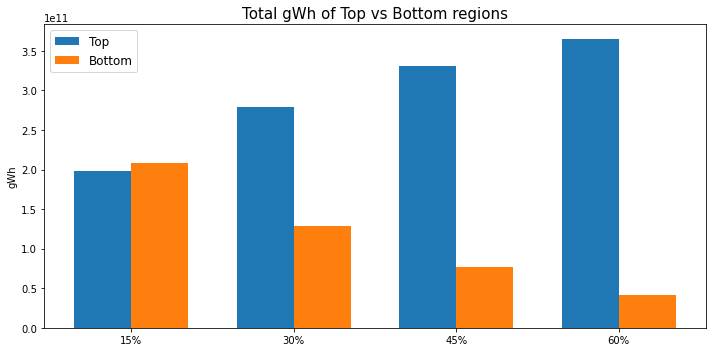

In [145]:
labels = ['15%', '30%', '45%', '60%']
Top = [top_15p, top_30p, top_45p, top_60p]
Bottom = [bot_85p, bot_70p, bot_55p, bot_40p]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(1, 1, figsize = (10,5))
rects1 = ax.bar(x - width/2, Top, width, label='Top')
rects2 = ax.bar(x + width/2, Bottom, width, label='Bottom')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('gWh')
ax.set_title('Total gWh of Top vs Bottom regions', fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize = 12)


fig.tight_layout()

plt.show()

fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/TopvBot_Regions.png")

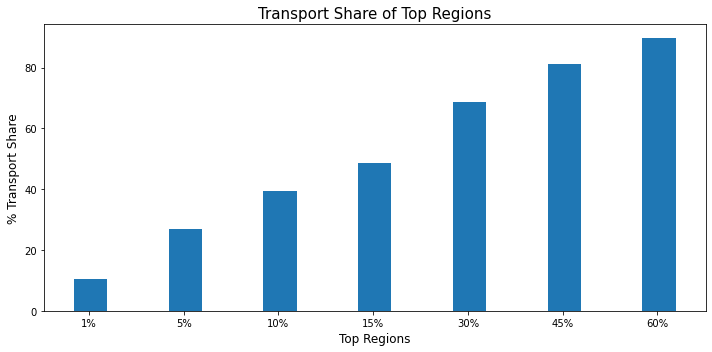

In [146]:
labels = ['1%', '5%', '10%', '15%', '30%', '45%', '60%']
Top = [P_top1p, P_top5p, P_top10p, P_top15p, P_top30p, P_top45p, P_top60p]
#Bottom = [bot_85p, bot_70p, bot_55p, bot_40p]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(1, 1, figsize = (10,5))
rects1 = ax.bar(x + width/20, Top, width, label='Top')
#rects2 = ax.bar(x + width/2, Bottom, width, label='Bottom')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% Transport Share', fontsize = 12)
ax.set_xlabel('Top Regions', fontsize = 12)
ax.set_title('Transport Share of Top Regions', fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.legend(fontsize = 12)


fig.tight_layout()

plt.show()

fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/%_Demand_Top_Regions.png")

In [147]:
bot_40p

41870816206.87672

Top Regions summed up by country

In [148]:
top_1p_regions_t_d
top_5p_regions_t_d
top_10p_regions_t_d
top_15p_regions_t_d
top_30p_regions_t_d
top_45p_regions_t_d
top_60p_regions_t_d

id
AT112    1.742881e+08
AT121    4.152325e+08
AT122    2.892881e+08
AT123    2.224983e+08
AT124    2.579951e+08
             ...     
UKM78    1.928363e+08
UKM82    1.902129e+08
UKM84    3.313768e+08
UKM92    2.380037e+08
UKM95    1.885737e+08
Name: 2050, Length: 829, dtype: float64

In [149]:
top_10p_regions_t_d

id
AT130    8.486773e+08
AT221    6.264633e+08
AT312    1.265345e+09
BE211    1.209012e+09
BE234    7.020146e+08
             ...     
SK031    6.795805e+08
SK042    6.501391e+08
UKF24    6.465100e+08
UKG24    7.702011e+08
UKH14    7.493096e+08
Name: 2050, Length: 139, dtype: float64

In [150]:
top_15p_regions_t_d

2050
id    country              
AT127 AT       5.735291e+08
AT130 AT       8.486773e+08
AT221 AT       6.264633e+08
AT312 AT       1.265345e+09
AT323 AT       5.296183e+08
...                     ...
UKF30 UK       5.666393e+08
UKG13 UK       5.423929e+08
UKG24 UK       7.702011e+08
UKH14 UK       7.493096e+08
UKH32 UK       5.352266e+08

[208 rows x 1 columns]

In [151]:
#top_15p_regions_t_d = top_15p_regions_t_d.to_frame()
#top_15p_regions_t_d = top_15p_regions_t_d.reset_index()
#country_codes = top_15p_regions_t_d.id.str.slice(stop=2)
#country_codes = country_codes.to_frame(name = 'country')
#top_15p_regions_t_d = top_15p_regions_t_d.reset_index()
#top_15p_regions_t_d = top_15p_regions_t_d.join(country_codes)
#top_15p_regions_t_d = top_15p_regions_t_d.set_index(['id','country'])

In [152]:
top_1p_regions_t_d = top_1p_regions_t_d.to_frame()
top_1p_regions_t_d = top_1p_regions_t_d.reset_index()
country_codes = top_1p_regions_t_d.id.str.slice(stop=2)
country_codes = country_codes.to_frame(name = 'country')
#top_15p_regions_t_d = top_15p_regions_t_d.reset_index()
top_1p_regions_t_d = top_1p_regions_t_d.join(country_codes)
top_1p_regions_t_d = top_1p_regions_t_d.set_index(['id','country'])

<AxesSubplot:xlabel='country'>

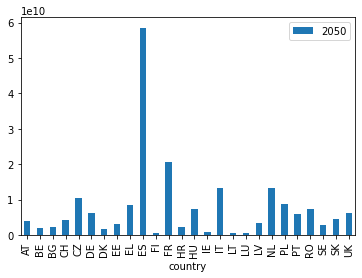

In [153]:
top_15p_country_t_d = top_15p_regions_t_d.groupby('country').sum()
top_1p_regions_t_d = top_1p_regions_t_d.groupby('country').sum()
top_15p_country_t_d.plot(kind = 'bar')

<AxesSubplot:xlabel='country'>

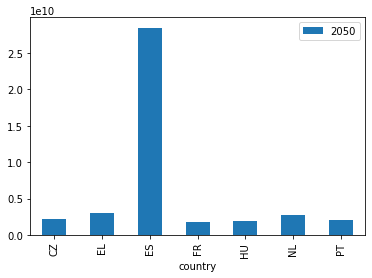

In [154]:
top_1p_regions_t_d.plot(kind = 'bar')

# Map top regions in transport demand per km road

In [155]:
t_d_NUTS3_divkm_2050_q85 = T_d_Region_divkm[2050].quantile(q = 0.85)

In [156]:
top_15p_regions_t_d_divkm = T_d_Region_divkm[T_d_Region_divkm[2050] > 1065886.6673292108]

In [157]:
top_15p_regions_t_d_divkm_2050 = top_15p_regions_t_d_divkm.loc[:,2050]

In [158]:
pd.set_option('display.max_rows', 300)  # or 1000


In [159]:
top_15p_regions_t_d_divkm_2050 = top_15p_regions_t_d_divkm_2050.to_frame()
top_15p_regions_t_d_divkm_2050 = top_15p_regions_t_d_divkm_2050.reset_index()
country_codes = top_15p_regions_t_d_divkm_2050.id.str.slice(stop=2)
country_codes = country_codes.to_frame(name = 'country')
#top_15p_regions_t_d = top_15p_regions_t_d.reset_index()
top_15p_regions_t_d_divkm_2050 = top_15p_regions_t_d_divkm_2050.join(country_codes)
top_15p_regions_t_d_divkm_2050 = top_15p_regions_t_d_divkm_2050.set_index(['id','country'])
top_15p_regions_t_d_divkm_2050

2050
id    country              
AT127 AT       1.089260e+06
AT130 AT       4.718040e+06
AT221 AT       1.853132e+06
AT312 AT       1.774038e+06
BE211 BE       2.268803e+06
BE236 BE       1.661872e+06
BE251 BE       1.148867e+06
BE257 BE       1.525404e+06
BE324 BE       2.452348e+06
BG411 BG       3.854194e+06
CH013 CH       1.175216e+06
CH023 CH       1.272197e+06
CH031 CH       4.453132e+06
CH032 CH       1.649655e+06
CH061 CH       1.148983e+06
CZ010 CZ       2.685333e+06
DE111 DE       5.117836e+06
DE113 DE       1.088629e+06
DE122 DE       9.406449e+06
DE126 DE       4.764459e+06
DE131 DE       1.084630e+06
DE144 DE       2.860706e+06
DE211 DE       3.147369e+06
DE212 DE       4.322953e+06
DE221 DE       1.163234e+06
DE223 DE       1.444245e+06
DE252 DE       1.392343e+06
DE253 DE       1.978066e+06
DE254 DE       4.757688e+06
DE261 DE       3.514626e+06
DE263 DE       1.168679e+06
DE271 DE       3.308465e+06
DE274 DE       6.569933e+06
DE300 DE       2.310562e+06
DE401 DE       1.425051e+06
DE403 DE       1.247058e+06
DE501 DE       5.168286e+06
DE502 DE       1.425628e+07
DE600 DE       5.709623e+06
DE711 DE       1.608556e+06
DE712 DE       2.376763e+06
DE714 DE       1.301875e+06
DE717 DE       1.305968e+06
DE71C DE       1.100155e+06
DE731 DE       2.309815e+06
DE803 DE       4.589361e+06
DE911 DE       1.617089e+06
DE912 DE       1.924562e+06
DE913 DE       4.224348e+06
DE929 DE       1.263853e+06
DE941 DE       1.420549e+06
DE942 DE       1.726069e+06
DE943 DE       2.163365e+06
DE944 DE       2.428171e+06
DE94F DE       1.223830e+06
DEA11 DE       4.877041e+06
DEA12 DE       7.342297e+06
DEA13 DE       1.803133e+06
DEA14 DE       9.465568e+06
DEA15 DE       2.071173e+06
DEA16 DE       1.331599e+06
DEA17 DE       1.678556e+06
DEA19 DE       2.335049e+06
DEA1A DE       2.458109e+06
DEA1D DE       1.515865e+06
DEA23 DE       2.872072e+06
DEA24 DE       2.958925e+06
DEA27 DE       1.427343e+06
DEA31 DE       2.051084e+06
DEA32 DE       4.472852e+06
DEA33 DE       1.289480e+06
DEA36 DE       1.295074e+06
DEA41 DE       1.942314e+06
DEA42 DE       1.428236e+06
DEA51 DE       1.811659e+06
DEA52 DE       4.816226e+06
DEA53 DE       2.986894e+06
DEA54 DE       3.606608e+06
DEA55 DE       5.516140e+06
DEA5C DE       1.415726e+06
DEB11 DE       3.235464e+06
DEB31 DE       1.217371e+06
DEB34 DE       9.153689e+06
DEB35 DE       2.645291e+06
DEB38 DE       2.347041e+06
DEB39 DE       2.542162e+06
DEB3E DE       1.490590e+06
DEC04 DE       1.162091e+06
DED41 DE       1.457092e+06
DED51 DE       4.626087e+06
DEE03 DE       2.659918e+06
DEF01 DE       3.095043e+06
DEF02 DE       2.097634e+06
DEF03 DE       2.539450e+06
DEF04 DE       3.844934e+06
DEG01 DE       1.896824e+06
DEG02 DE       1.610654e+06
DEG05 DE       1.251481e+06
DK011 DK       2.426084e+06
DK012 DK       1.089935e+06
EE001 EE       2.659953e+06
EL301 EL       3.773855e+06
EL302 EL       1.925015e+06
EL303 EL       1.083381e+07
EL304 EL       1.615965e+06
EL306 EL       2.540832e+06
EL307 EL       2.324209e+06
EL522 EL       1.898354e+06
ES211 ES       1.256450e+06
ES212 ES       1.951297e+06
ES213 ES       1.878947e+06
ES300 ES       1.811239e+06
ES511 ES       3.162940e+06
ES521 ES       1.093506e+06
ES523 ES       2.366077e+06
ES611 ES       1.169060e+06
ES620 ES       1.281815e+06
FR101 FR       8.911652e+06
FR107 FR       1.915977e+06
FRK26 FR       1.077740e+06
HR041 HR       3.059734e+06
HU110 HU       4.662386e+06
ITC46 IT       1.099149e+06
ITC4C IT       2.264455e+06
ITF33 IT       1.178007e+06
ITH31 IT       1.140327e+06
ITI15 IT       1.525640e+06
ITI16 IT       1.912949e+06
LV006 LV       1.882260e+07
NL112 NL       2.177889e+06
NL113 NL       1.068990e+06
NL133 NL       1.304679e+06
NL211 NL       1.092022e+06
NL212 NL       1.395891e+06
NL213 NL       1.329199e+06
NL221 NL       1.310914e+06
NL224 NL       1.471276e+06
NL225 NL       1.209354e+06
NL226 NL       1.606111e+06
NL230 NL       1.198123e+06
NL310 NL       1.196950e+06
NL321 NL       1.06

In [160]:
top_15p_regions_t_d_divkm_2050.mean()

2050    2.582801e+06
dtype: float64

In [161]:
pd.set_option('display.max_rows', 300)  # or 1000
#top_15p_regions_t_d_divkm_2050.sort_values(by = [2050])

In [162]:
pd.set_option('display.max_rows', 5)  # or 1000
top_15p_regions_t_d_divkm_2050_PL = top_15p_regions_t_d_divkm_2050.filter(like = 'PT', axis = 0)
top_15p_regions_t_d_divkm_2050_PL.mean()

2050    1.679915e+06
dtype: float64

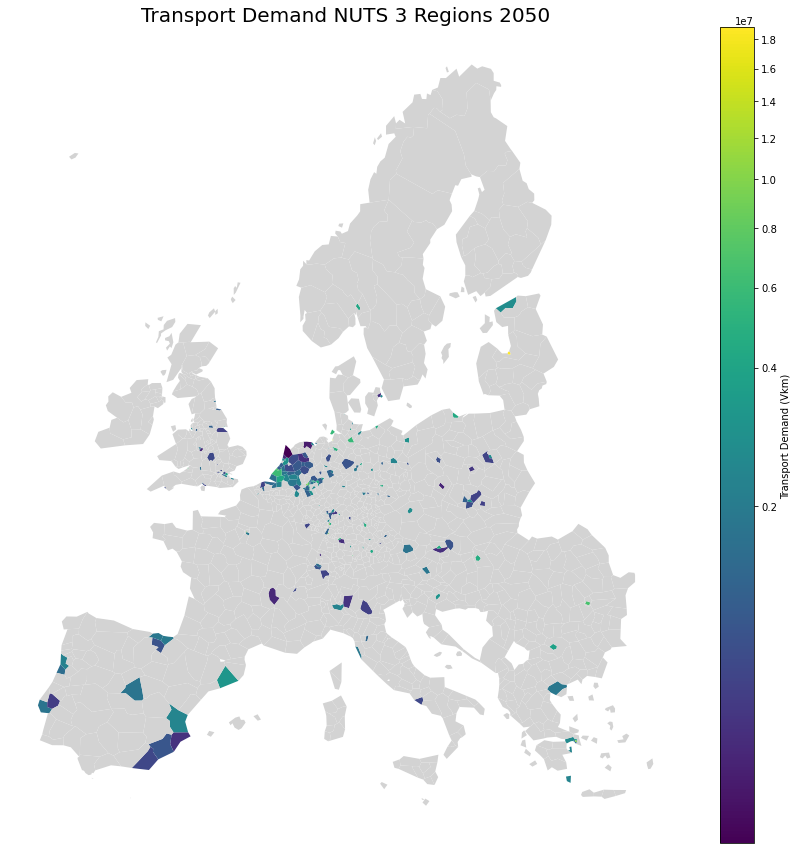

In [163]:
# Plot 15% top regions in transport demand per km road
gdf_top_15p_regions_t_d_divkm = gdf_dw.join(top_15p_regions_t_d_divkm)
gdf_top_15p_regions_t_d_divkm = gdf_top_15p_regions_t_d_divkm.replace(0, np.nan)

fig, ax2 = plt.subplots(1, 1, figsize = (15,15))
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.5)
ax2.axis('off')
ax2.set_title("Transport Demand NUTS 3 Regions 2050", fontsize=20)

gdf_top_15p_regions_t_d_divkm.plot(column = 2050, 
                         ax=ax2,
                        legend=True,
                        cax = cax2,
                        legend_kwds = {'label': 'Transport Demand (Vkm)'},
                        cmap = 'viridis',
                        norm=mcolors.PowerNorm(0.3),
                        missing_kwds= dict(color = "lightgrey"))

fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/Top15p_TransportDemand_divkm.png")

In [164]:
t_d_NUTS3_divkm_2050_q70 = T_d_Region_divkm[2050].quantile(q = 0.70)

In [165]:
top_30p_regions_t_d_divkm = T_d_Region_divkm[T_d_Region_divkm[2050] > 569382.9008432499]

<AxesSubplot:>

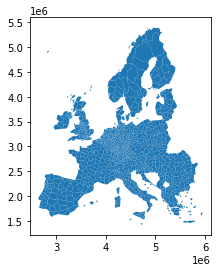

In [166]:
gdf_dw.plot()

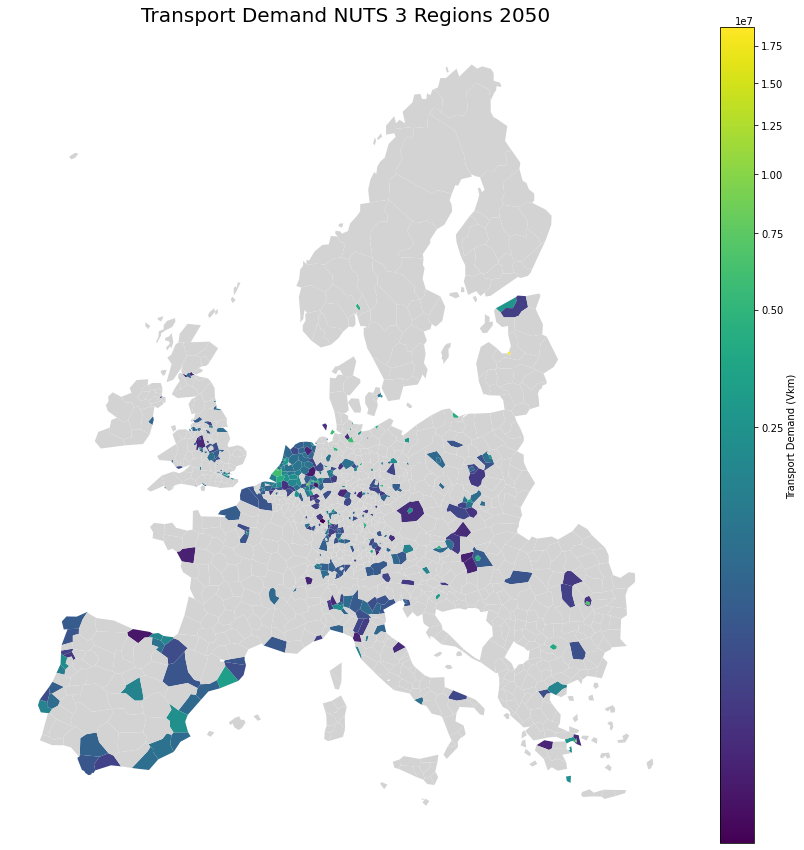

In [167]:
# Plot 30% top regions in transport demand per km road
gdf_top_30p_regions_t_d_divkm = gdf_dw.join(top_30p_regions_t_d_divkm)
gdf_top_30p_regions_t_d_divkm = gdf_top_30p_regions_t_d_divkm.replace(0, np.nan)

fig, ax2 = plt.subplots(1, 1, figsize = (15,15))
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.5)
ax2.axis('off')
ax2.set_title("Transport Demand NUTS 3 Regions 2050", fontsize=20)

gdf_top_30p_regions_t_d_divkm.plot(column = 2050, 
                         ax=ax2,
                        legend=True,
                        cax = cax2,
                        legend_kwds = {'label': 'Transport Demand (Vkm)'},
                        cmap = 'viridis',
                        norm=mcolors.PowerNorm(0.3),
                        missing_kwds= dict(color = "lightgrey"))

fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/Top30p_TransportDemand_divkm.png")

In [168]:
t_d_NUTS3_divkm_2050_q55 = T_d_Region_divkm[2050].quantile(q = 0.55)

In [169]:
top_45p_regions_t_d_divkm = T_d_Region_divkm[T_d_Region_divkm[2050] > 400458.6435766475]

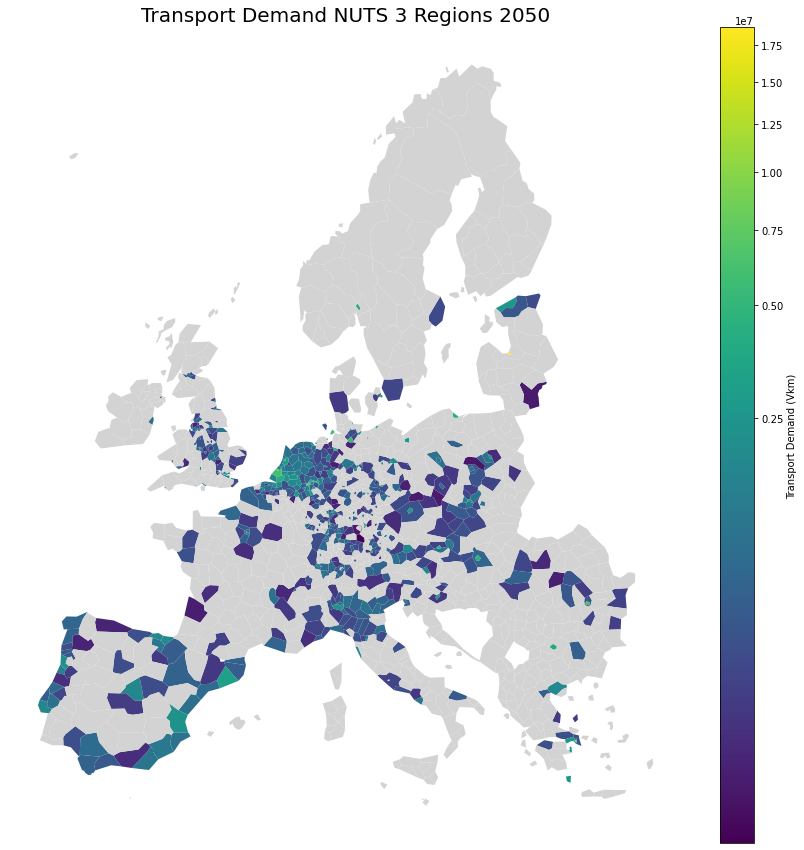

In [170]:
# Plot 45% top regions in transport demand per km road
gdf_top_45p_regions_t_d_divkm = gdf_dw.join(top_45p_regions_t_d_divkm)
gdf_top_45p_regions_t_d_divkm = gdf_top_45p_regions_t_d_divkm.replace(0, np.nan)

fig, ax2 = plt.subplots(1, 1, figsize = (15,15))
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.5)
ax2.axis('off')
ax2.set_title("Transport Demand NUTS 3 Regions 2050", fontsize=20)

gdf_top_45p_regions_t_d_divkm.plot(column = 2050, 
                         ax=ax2,
                        legend=True,
                        cax = cax2,
                        legend_kwds = {'label': 'Transport Demand (Vkm)'},
                        cmap = 'viridis',
                        norm=mcolors.PowerNorm(0.3),
                        missing_kwds= dict(color = "lightgrey"))

fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/Top45p_TransportDemand_divkm.png")

In [171]:
t_d_NUTS3_divkm_2050_q40 = T_d_Region_divkm[2050].quantile(q = 0.40)

In [172]:
top_60p_regions_t_d_divkm = T_d_Region_divkm[T_d_Region_divkm[2050] > 286139.47005562735]

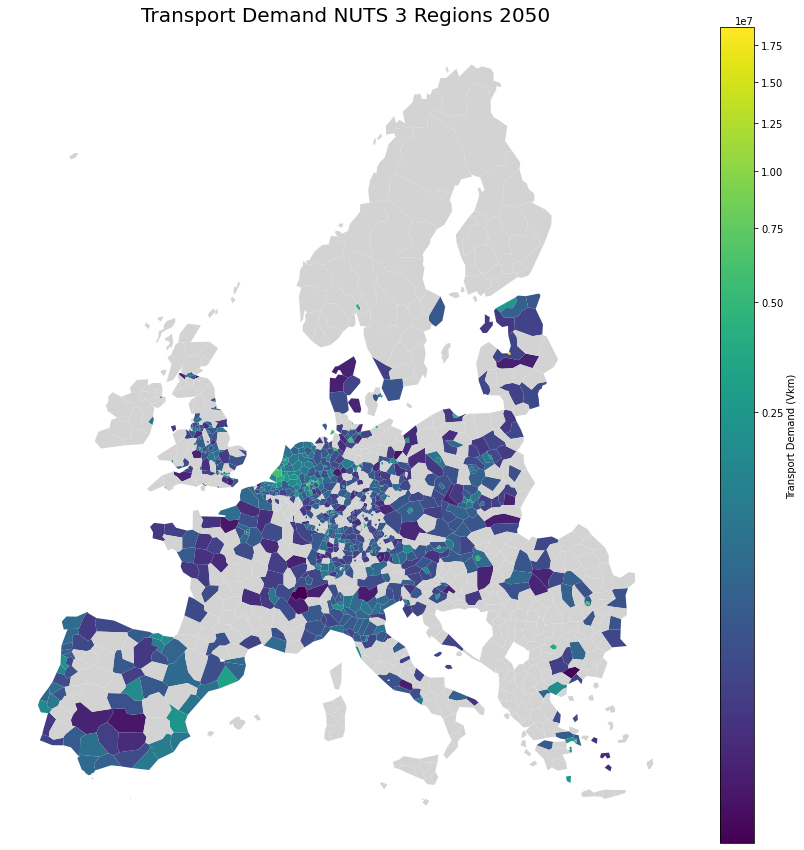

In [173]:
# Plot 60% top regions in transport demand per km road
gdf_top_60p_regions_t_d_divkm = gdf_dw.join(top_60p_regions_t_d_divkm)
gdf_top_60p_regions_t_d_divkm = gdf_top_60p_regions_t_d_divkm.replace(0, np.nan)

fig, ax2 = plt.subplots(1, 1, figsize = (15,15))
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.5)
ax2.axis('off')
ax2.set_title("Transport Demand NUTS 3 Regions 2050", fontsize=20)

gdf_top_60p_regions_t_d_divkm.plot(column = 2050, 
                         ax=ax2,
                        legend=True,
                        cax = cax2,
                        legend_kwds = {'label': 'Transport Demand (Vkm)'},
                        cmap = 'viridis',
                        norm=mcolors.PowerNorm(0.3),
                        missing_kwds= dict(color = "lightgrey"))

fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/Top60p_TransportDemand_divkm.png")

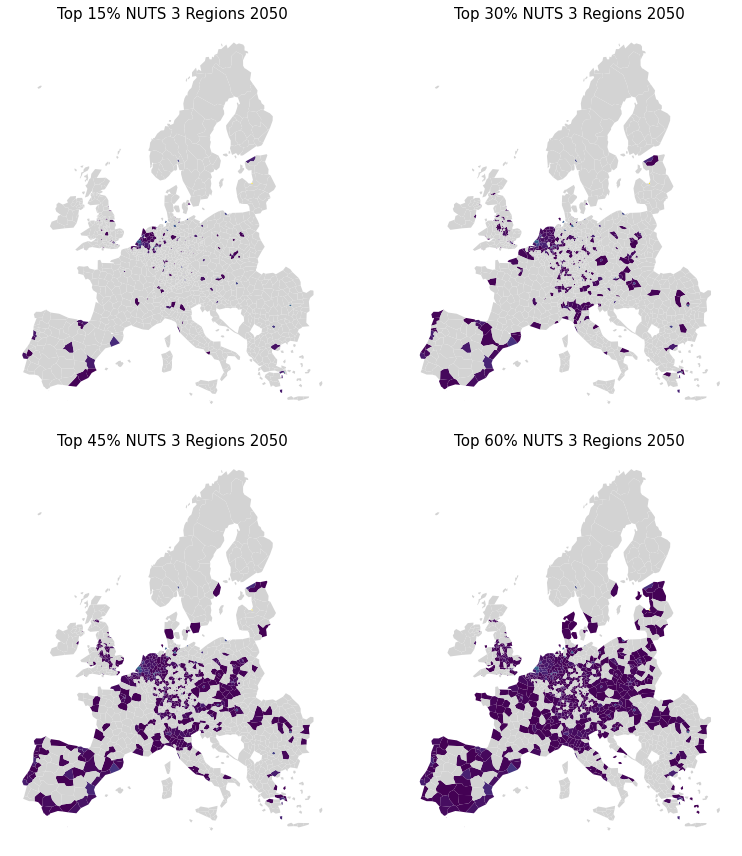

In [174]:
#all top region plots in one 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

#Top 10%
ax1.axis('off')
ax1.set_title("Top 15% NUTS 3 Regions 2050", fontsize=15)
#Top 20%
ax2.axis('off')
ax2.set_title("Top 30% NUTS 3 Regions 2050", fontsize=15)
#Top 30%
ax3.axis('off')
ax3.set_title("Top 45% NUTS 3 Regions 2050", fontsize=15)
#Top 40%
ax4.axis('off')
ax4.set_title("Top 60% NUTS 3 Regions 2050", fontsize=15)

gdf_top_15p_regions_t_d_divkm.plot(column = 2050, 
                         ax=ax1,
                        missing_kwds= dict(color = "lightgrey"))
gdf_top_30p_regions_t_d_divkm.plot(column = 2050, 
                         ax=ax2,
                        missing_kwds= dict(color = "lightgrey"))
gdf_top_45p_regions_t_d_divkm.plot(column = 2050, 
                         ax=ax3,
                        missing_kwds= dict(color = "lightgrey"))
gdf_top_60p_regions_t_d_divkm.plot(column = 2050, 
                         ax=ax4,
                        missing_kwds= dict(color = "lightgrey"))
plt.tight_layout()

fig.savefig("C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Pandas_Plots/TopRegionPlots.png")

# Multiple Linear Regression For Transport Demand 

In [175]:
Vkm = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'Vkm_1999-2019_P')
Vkm = Vkm.set_index('country')
GDP = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'GDP_1999-2019_P')
GDP = GDP.set_index('country')
GDPc = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'GDPc_1999-2019_P')
GDPc = GDPc.set_index('country')
Pop = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'Pop_1999-2019_P')
Pop = Pop.set_index('country')
FuelPrice = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'Fuel_Price_1999-2019_P')
FuelPrice = FuelPrice.set_index('country')
Size = pd.read_excel('C:/Users/seanp/OneDrive/Documents/ETH/Master Thesis/Model/Transport Demand Prediction/Transport_Demand_Prediction.xlsm', sheet_name = 'Country_Size_P')
Size = Size.set_index('country')

XLRDError: No sheet named <'Vkm_1999-2019_P'>

In [ ]:
GDP.columns = GDP.columns.astype(str)
Vkm.columns = Vkm.columns.astype(str)
print(GDP.columns)
print(Vkm.columns)

In [ ]:
Vkm.align(GDP)

In [ ]:
Vkm

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,15))
FuelPrice.T.plot(ax=ax)

In [ ]:
x = GDP
y = Vkm

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

predictions

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,15))
predictions.T.plot(ax=ax)

# Test area

In [ ]:
toe_mio_Vkm_country.columns = ['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016','2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030']
toe_mio_Vkm_country

In [ ]:
gdf_MWh_region = gdf_dw.join(MWh_region)
gdf_MWh_region = gdf_MWh_region.drop(['ES708', 'ES704', 'ES705', 'ES709', 'ES706', 'ES703', 'ES707', 'CY000', 'FRY10', 'FRY20', 'FRY30', 'FRY40', 'FRY50', 'PT300', 'PT200'])
fig, ax = plt.subplots(1, 1, figsize = (20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)

gdf_MWh_region.plot(column = '2019', 
         ax = ax, 
         legend=True,
         cax = cax,
         legend_kwds = {'label': 'energy consumption (mwh)'},
         cmap = 'viridis',
         missing_kwds= dict(color = "lightgrey")
         )

In [ ]:
maxValuesObj = MWh_region_filledna.max()
pd.set_option("display.max_rows", 50, "display.max_columns", 50)
MWh_region_filledna.loc[(slice(None), 'FR'), :]

gdf_MWh_region_select = gdf_MWh_region.cx[0.22:,1:]

In [ ]:
toe_mio_Vkm_country.columns = toe_mio_Vkm_country.columns.int.replace(' ', '')
print(toe_mio_Vkm_country.columns)

In [ ]:
MWh_region.columns = MWh_region.columns.str.replace(' ', '')
print(MWh_region.columns)

In [ ]:
MWh_region.columns = ['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016','2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030']
MWh_region

In [ ]:
#loading international transport dataset
df_unloading_int_EC = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_ia_ugtt.tsv.gz',['Type_of_carriage', 'Region', 'subsector', 'unit', 'country'])
df_loading_int_EC = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_ia_lgtt.tsv.gz',['Type_of_carriage', 'Region', 'subsector', 'unit', 'country'])
#filtering dataset to proper data
df_unloading_int_EC = df_unloading_int_EC.loc[('TOT', 'WORLD', 'TOTAL')]
df_unloading_int_EC = df_unloading_int_EC.droplevel(0)
df_loading_int_EC = df_loading_int_EC.loc[('TOT', 'WORLD', 'TOTAL')]
df_loading_int_EC = df_loading_int_EC.droplevel(0)
#average of loaning and unloading
df_average_transport_total_int_EC = pd.concat((df_loading_int_EC, df_unloading_int_EC))
df_average_transport_total_int_EC = df_average_transport_total_int_EC.groupby(df_average_transport_total_int_EC.index).mean()
#multiplay international transport with share of total national tranport for each region
international_transport_region = share_total_national_transport_region.multiply(df_average_transport_total_int_EC)
#sum of national and international transport
df_average_transport_total = df_average_transport_total.droplevel(1)
international_transport_region = international_transport_region.droplevel(1)
total_national_international_transport_region = pd.concat((international_transport_region, df_average_transport_total))
total_national_international_transport_region = total_national_international_transport_region.groupby('id').sum()
total_national_international_transport_region

In [ ]:
international_transport_region

In [ ]:
df_average_transport_total

In [ ]:
#devide total mio vehicle TKM by total transport per region to get km driven by trucks in that region
df_total_transport_mio_Tkm_region_EC = share_total_national_transport_region.multiply(df_total_transport_mio_Tkm_country_EC)
km_driven_region = df_total_transport_mio_Tkm_region_EC.divide(total_national_international_transport_region)
km_driven_region

In [ ]:
df_total_transport_mio_Tkm_region_EC

In [ ]:
df_total_transport_mio_Tkm_region_EC = share_total_national_transport_region.multiply(df_total_transport_mio_Tkm_country_EC)

In [ ]:
test = km_driven_region.iloc[1343:1522]

In [ ]:
print(gdf.iloc[0:5])

In [ ]:
#trying to use different dataset with total transport amount
df_unloading_test = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_ta_ru.tsv.gz',['subsector', 'unit', 'region'])

In [ ]:
idx = pd.IndexSlice
df_unloading_test = df_unloading_test.loc[idx[:,'THS_T'], :]
df_unloading_test = df_unloading_test.droplevel('unit')
df_unloading_test

In [ ]:
df_unloading_test = df_unloading_test.reindex(gdf.set_index('id').index)




df_unloading_test = df_unloading_test.loc[idx[:,['THS_T']]]
df_unloading_test = df_unloading_test.droplevel(1)
df_unloading_total = df_unloading.loc['THS_T']
df_unloading_test

In [ ]:
df_unloading_test = df_unloading_test.droplevel(0)

In [ ]:
#sorting gdf according to id so it might aligne with eurostats data
gdf_sort = gdf.sort_values(by=['id'])

In [ ]:
#selecting 2019 column
df_at_2019 = df_average_transport.iloc[:, 0]

In [ ]:
print(df_at_2019.iloc[100:105])

In [ ]:
gdf_sort['TRANSPORT_AMOUNT_2019'] = df_at_2019

In [ ]:
print(gdf_sort.iloc[100:150])

In [ ]:
gdf_sort.head()

In [ ]:
#alinge dataframes and delet all lines with no shared id